In [3]:
using Plots
using Zygote
using Printf
using JLD2
using DiffEqFlux
using Flux
using OrdinaryDiffEq
using BSON: @load

include("src/utils/graphic_tools.jl")
include("src/neural_ode/models.jl")
include("src/utils/processing_tools.jl")
include("src/utils/generators.jl")
include("src/examples/burgers/analysis.jl")
include("src/examples/burgers/burgers_direct.jl")

Main.BurgersDirect

---
# Hyper-parameter tuning

## Architecture - FNN

In [2]:
ho_nonoise = JLD2.load("./src/examples/burgers/models/feedforward2/hyperopt_result_fnn_nonoise.jld2")["ho"];
ho_05noise = JLD2.load("./src/examples/burgers/models/feedforward2/hyperopt_result_fnn_05noise.jld2")["ho"];
ho_15noise = JLD2.load("./src/examples/burgers/models/feedforward2/hyperopt_result_fnn_15noise.jld2")["ho"];

┌ Warning: type Hyperopt.Hyperoptimizer{Hyperopt.LHSampler,Main.#2017###hyperopt_objective#425#25} does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:461
┌ Warning: type Hyperopt.LHSampler does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:461
┌ Warning: type Hyperopt.Hyperoptimizer{Hyperopt.LHSampler,Main.#1188###hyperopt_objective#403#11} does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:461
┌ Warning: type Hyperopt.LHSampler does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:461
┌ Warning: type Hyperopt.Hyperoptimizer{Hyperopt.LHSampler,Main.#1603###hyperopt_objective#414#18} does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia

In [4]:
function get_d_train(ho)
    d = Dict([]);
    x =  [8, 16, 24, 32, 40];
    y = [1, 2, 3, 4, 5];

    for a in x
        for b in y
            d[(b, a)] = 1.;
        end
    end

    for (i, tupl) in enumerate(ho.history)
        d[tupl[1]] = ho.results[i];
    end
    
    return d
end

get_d_train (generic function with 1 method)

In [5]:
using BSON

function get_d_val(ho, dataset, filepath)
    (train_loader, val_loader) = ProcessingTools.get_data_loader(dataset, 32, 0.7, false, false);
    function val_loss(K, p, x, y, t)
        prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), AutoTsit5(Rosenbrock23()), saveat=t);
        ŷ = prob_neuralode(x, p);
        l = Flux.mse(ŷ, permutedims(y, (1, 3, 2)))
        return l;
    end
    
    function evalcb(K, p, val_loader)
        lval = 0;
        for (x, y, t) in val_loader
            lval += val_loss(K, p, x, y, t[1]);
        end
        lval /= (val_loader.nobs / val_loader.batchsize);
        return lval
    end
    
    d = Dict([]);
    x = [8, 16, 24, 32, 40];  # Remove 56 for no noise and 15% noise
    y = [1, 2, 3, 4, 5];

    for k in y
        for l in x
            d[(k, l)] = 1.;
        end
    end
    
    for (i, tupl) in enumerate(ho.history)
        d[tupl[1]] = ho.results[i];
    end
    
    for (i, tupl) in enumerate(ho.history)
        filename = filepath * string(i) * ".bson"
        BSON.@load filename K p;
        l = evalcb(K, p, val_loader);
        d[tupl[1]] = l;
    end
    
    return d
end

get_d_val (generic function with 1 method)

In [10]:
x =  [8, 16, 24, 32, 40];
y = [1, 2, 3, 4, 5];

d_nonoise = get_d_train(ho_nonoise);
d_05noise = get_d_train(ho_05noise);
d_15noise = get_d_train(ho_15noise);

function f(x, y, d)
    return d[(y, x)];
end

f (generic function with 1 method)

In [47]:
dataset = JLD2.load("./src/examples/burgers/dataset/burgers_high_dim_training_set.jld2")["training_set"];

In [26]:
d_val_nonoise = get_d_val(ho_nonoise, dataset, "./src/examples/burgers/models/feedforward2/tuning_burgers_fnn_nonoise_iter_");

Dict{Any, Any} with 25 entries:
  (1, 24) => 0.434847
  (5, 40) => 0.328162
  (5, 16) => 0.274743
  (3, 8)  => 0.337051
  (4, 32) => 0.279463
  (3, 24) => 0.281814
  (1, 40) => 0.298571
  (2, 32) => 0.306929
  (1, 16) => 0.309271
  (4, 8)  => 0.4467
  (5, 32) => 0.287703
  (2, 8)  => 0.309244
  (3, 40) => 0.432417
  (4, 24) => 0.274295
  (3, 16) => 0.337587
  (2, 24) => 0.328737
  (1, 32) => 0.308375
  (5, 8)  => 0.280309
  (5, 24) => 0.337911
  (4, 40) => 0.291304
  (2, 40) => 0.439751
  (4, 16) => 0.285132
  (1, 8)  => 0.277357
  (2, 16) => 0.440391
  (3, 32) => 0.303693

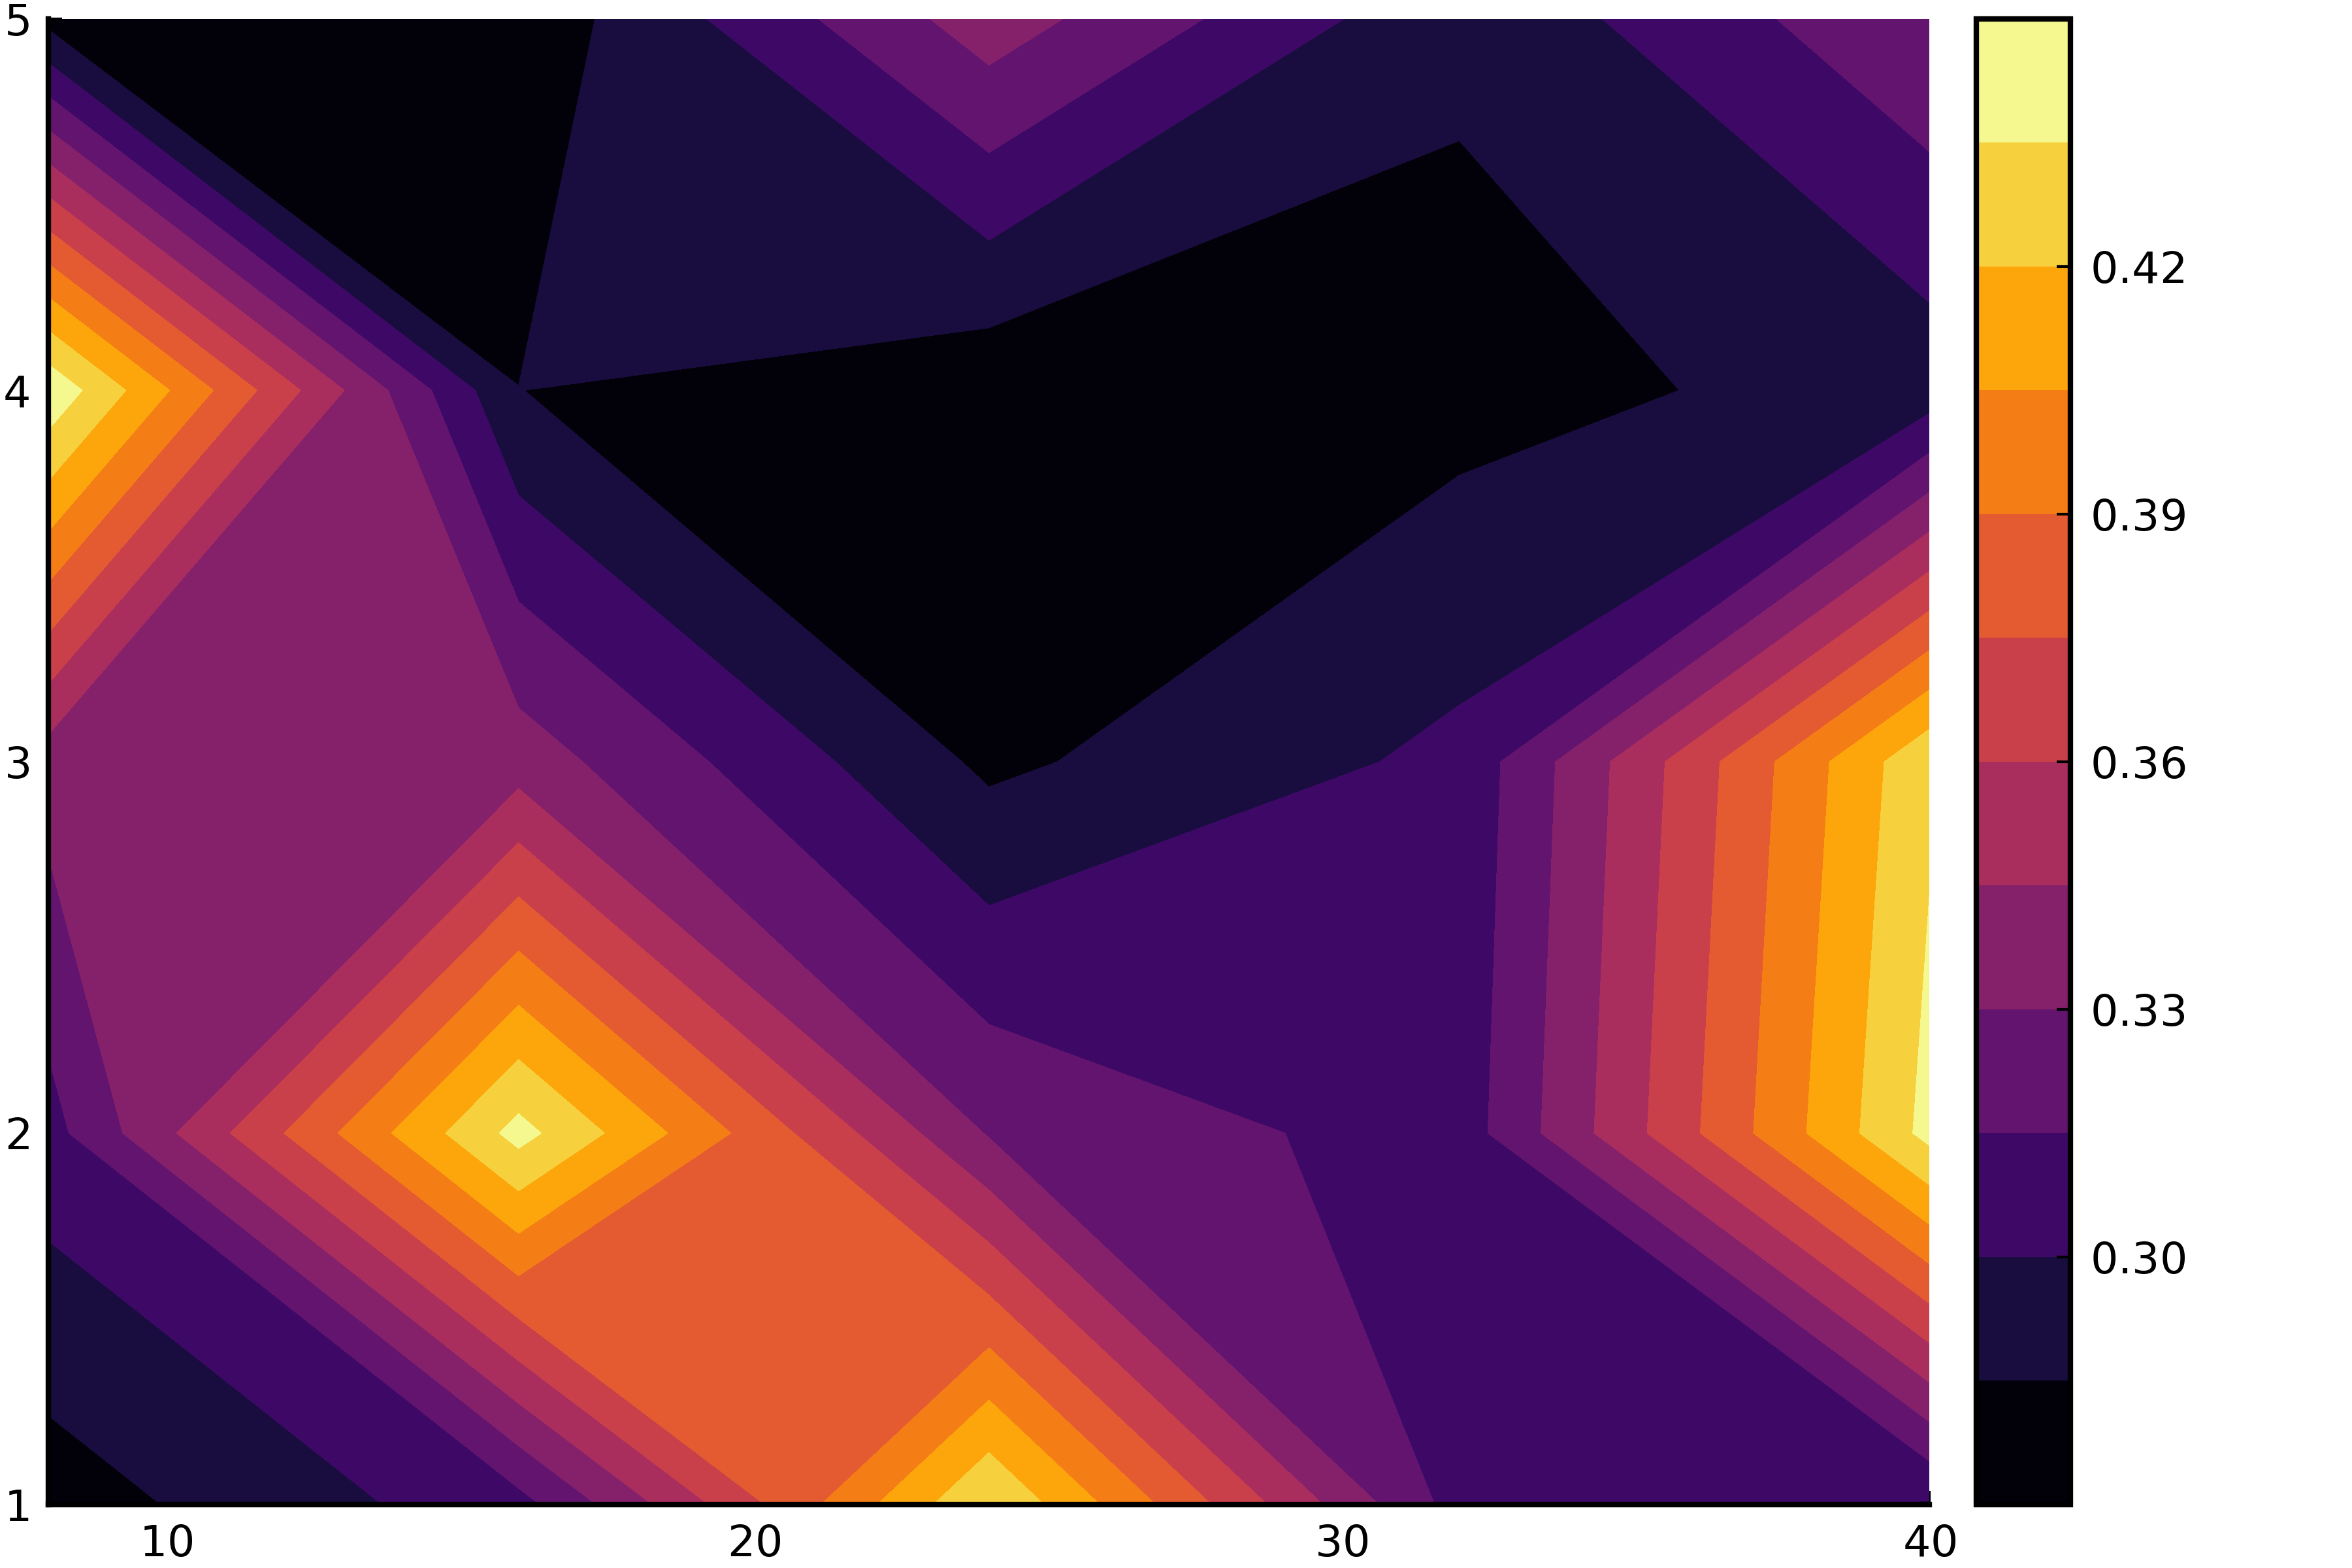

In [27]:
plot(contourf(x, y, (x, y) -> f(x, y, d_val_nonoise)), dpi=600)

In [28]:
d_val_05noise = get_d_val(ho_05noise, dataset, "./src/examples/burgers/models/feedforward2/tuning_burgers_fnn_05noise_iter_");

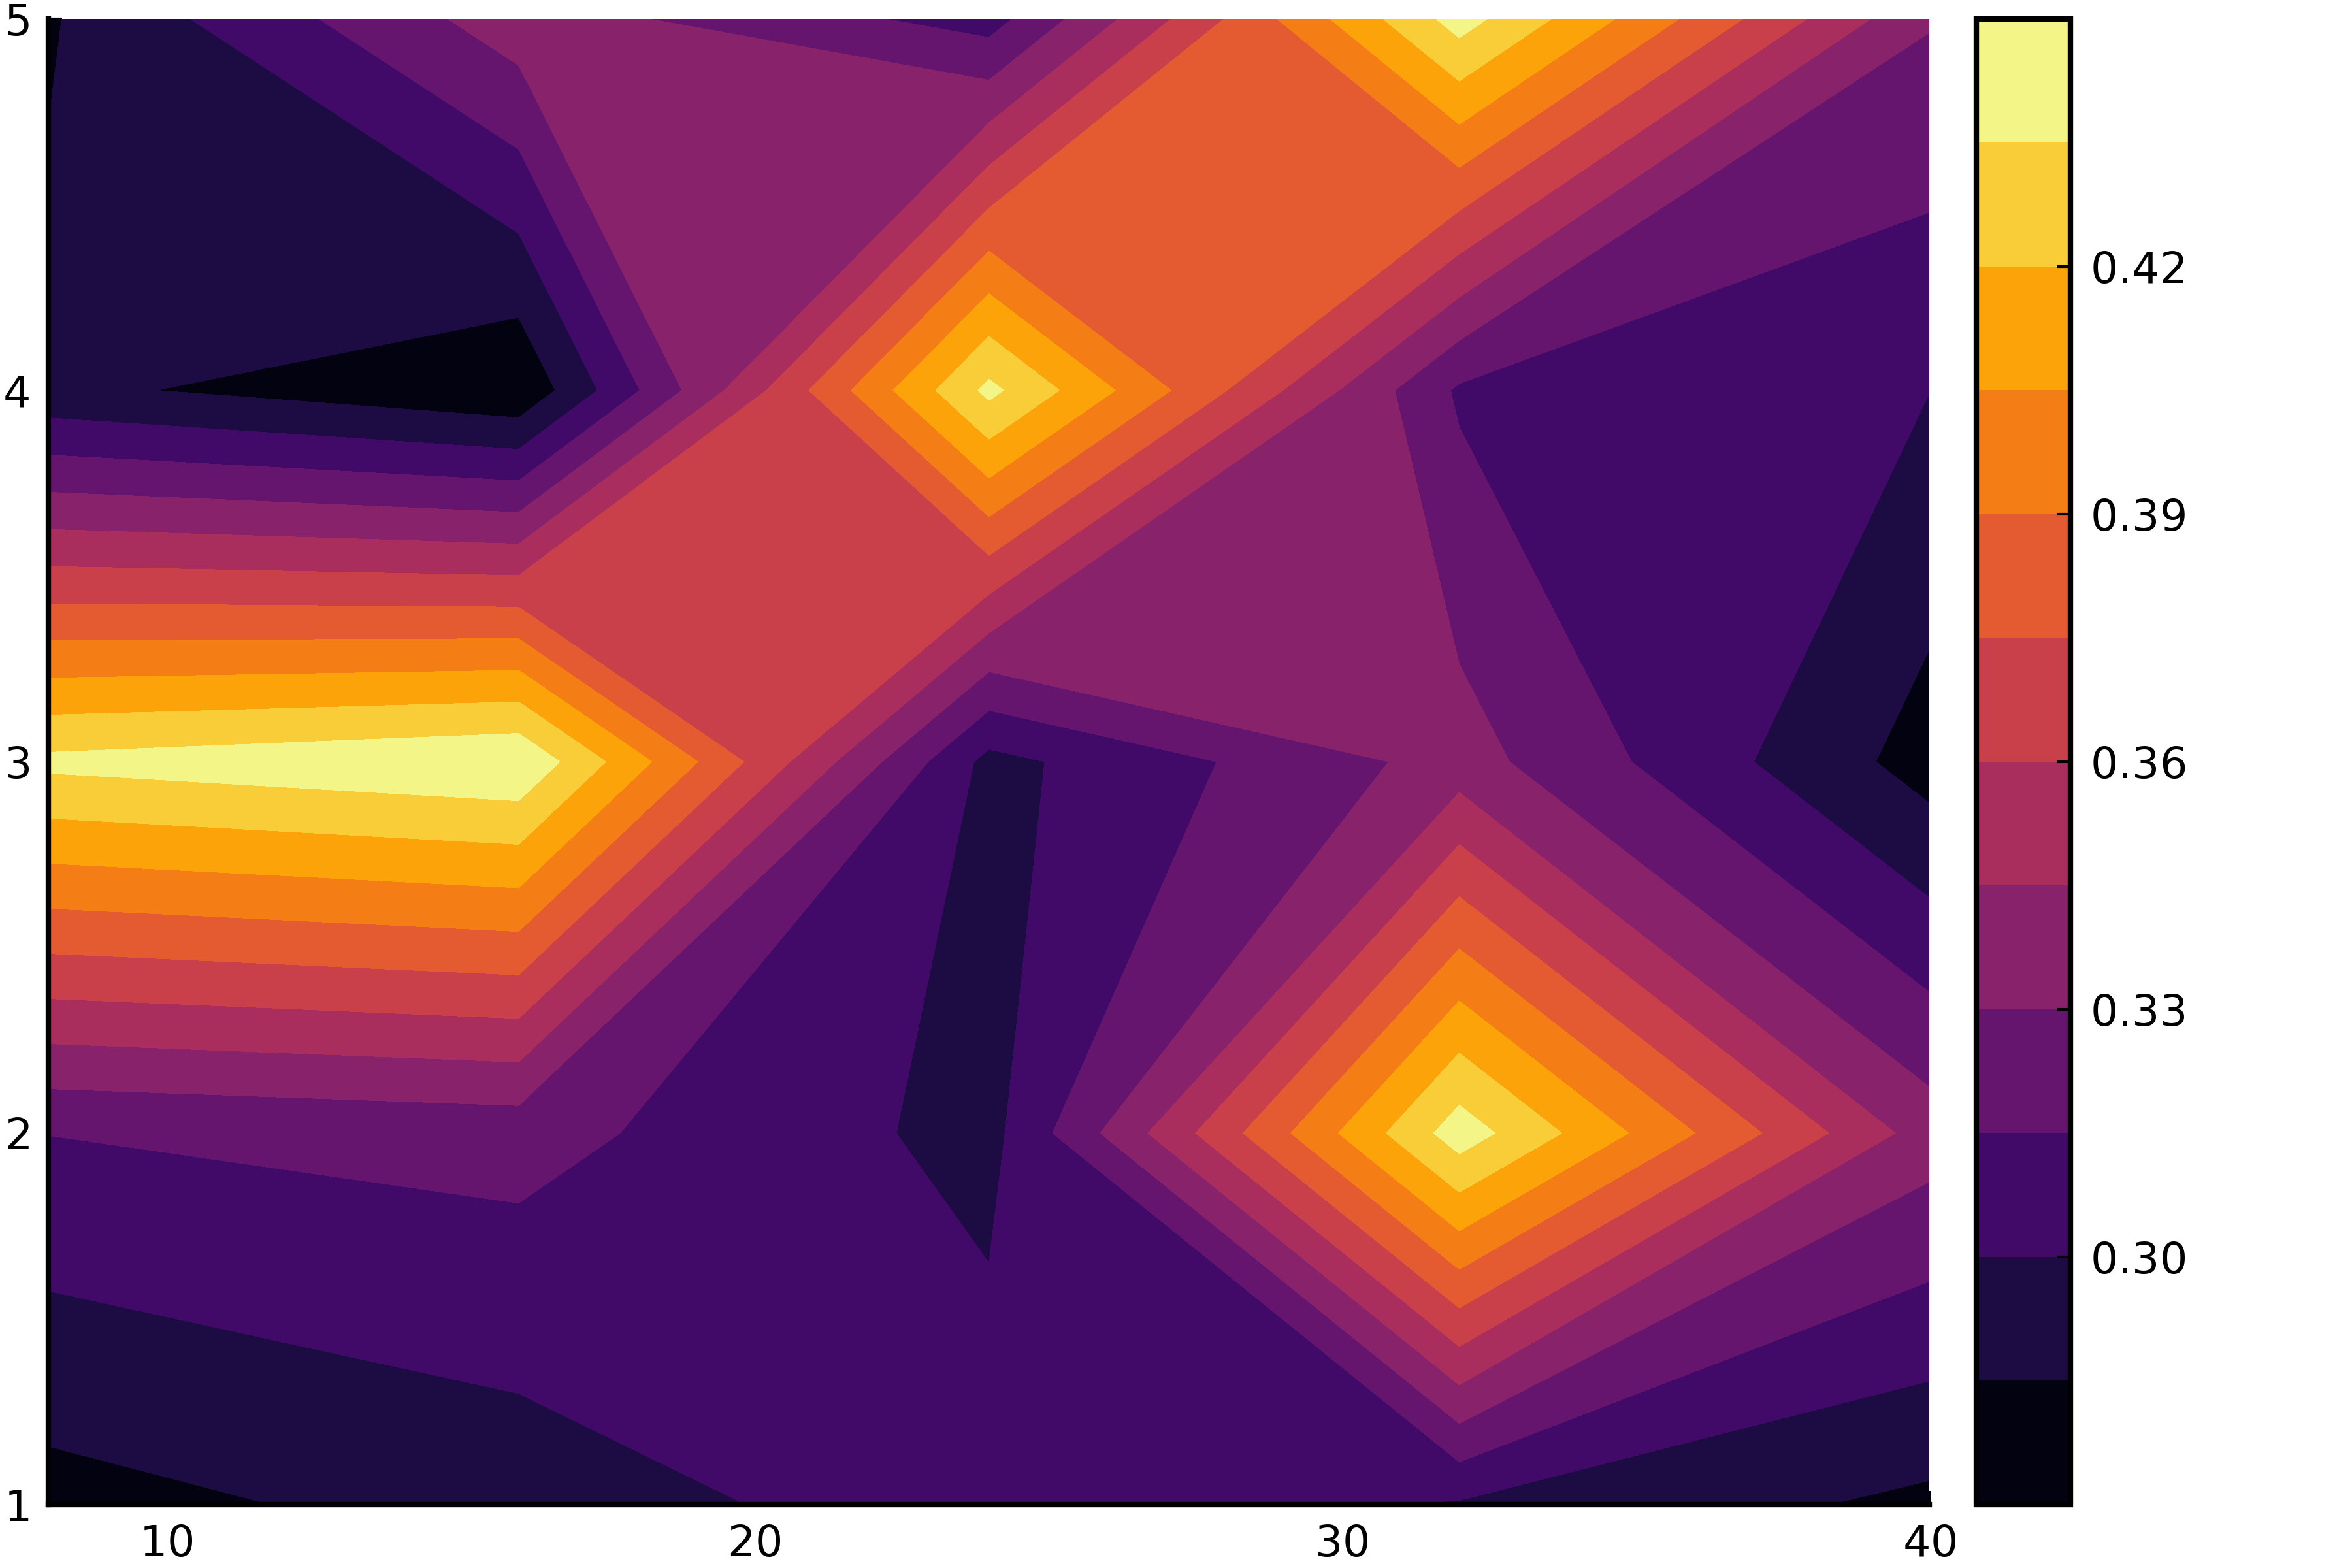

In [30]:
plot(contourf(x, y, (x, y) -> f(x, y, d_val_05noise)), dpi=600)

In [31]:
d_val_15noise = get_d_val(ho_15noise, dataset, "./src/examples/burgers/models/feedforward2/tuning_burgers_fnn_15noise_iter_");

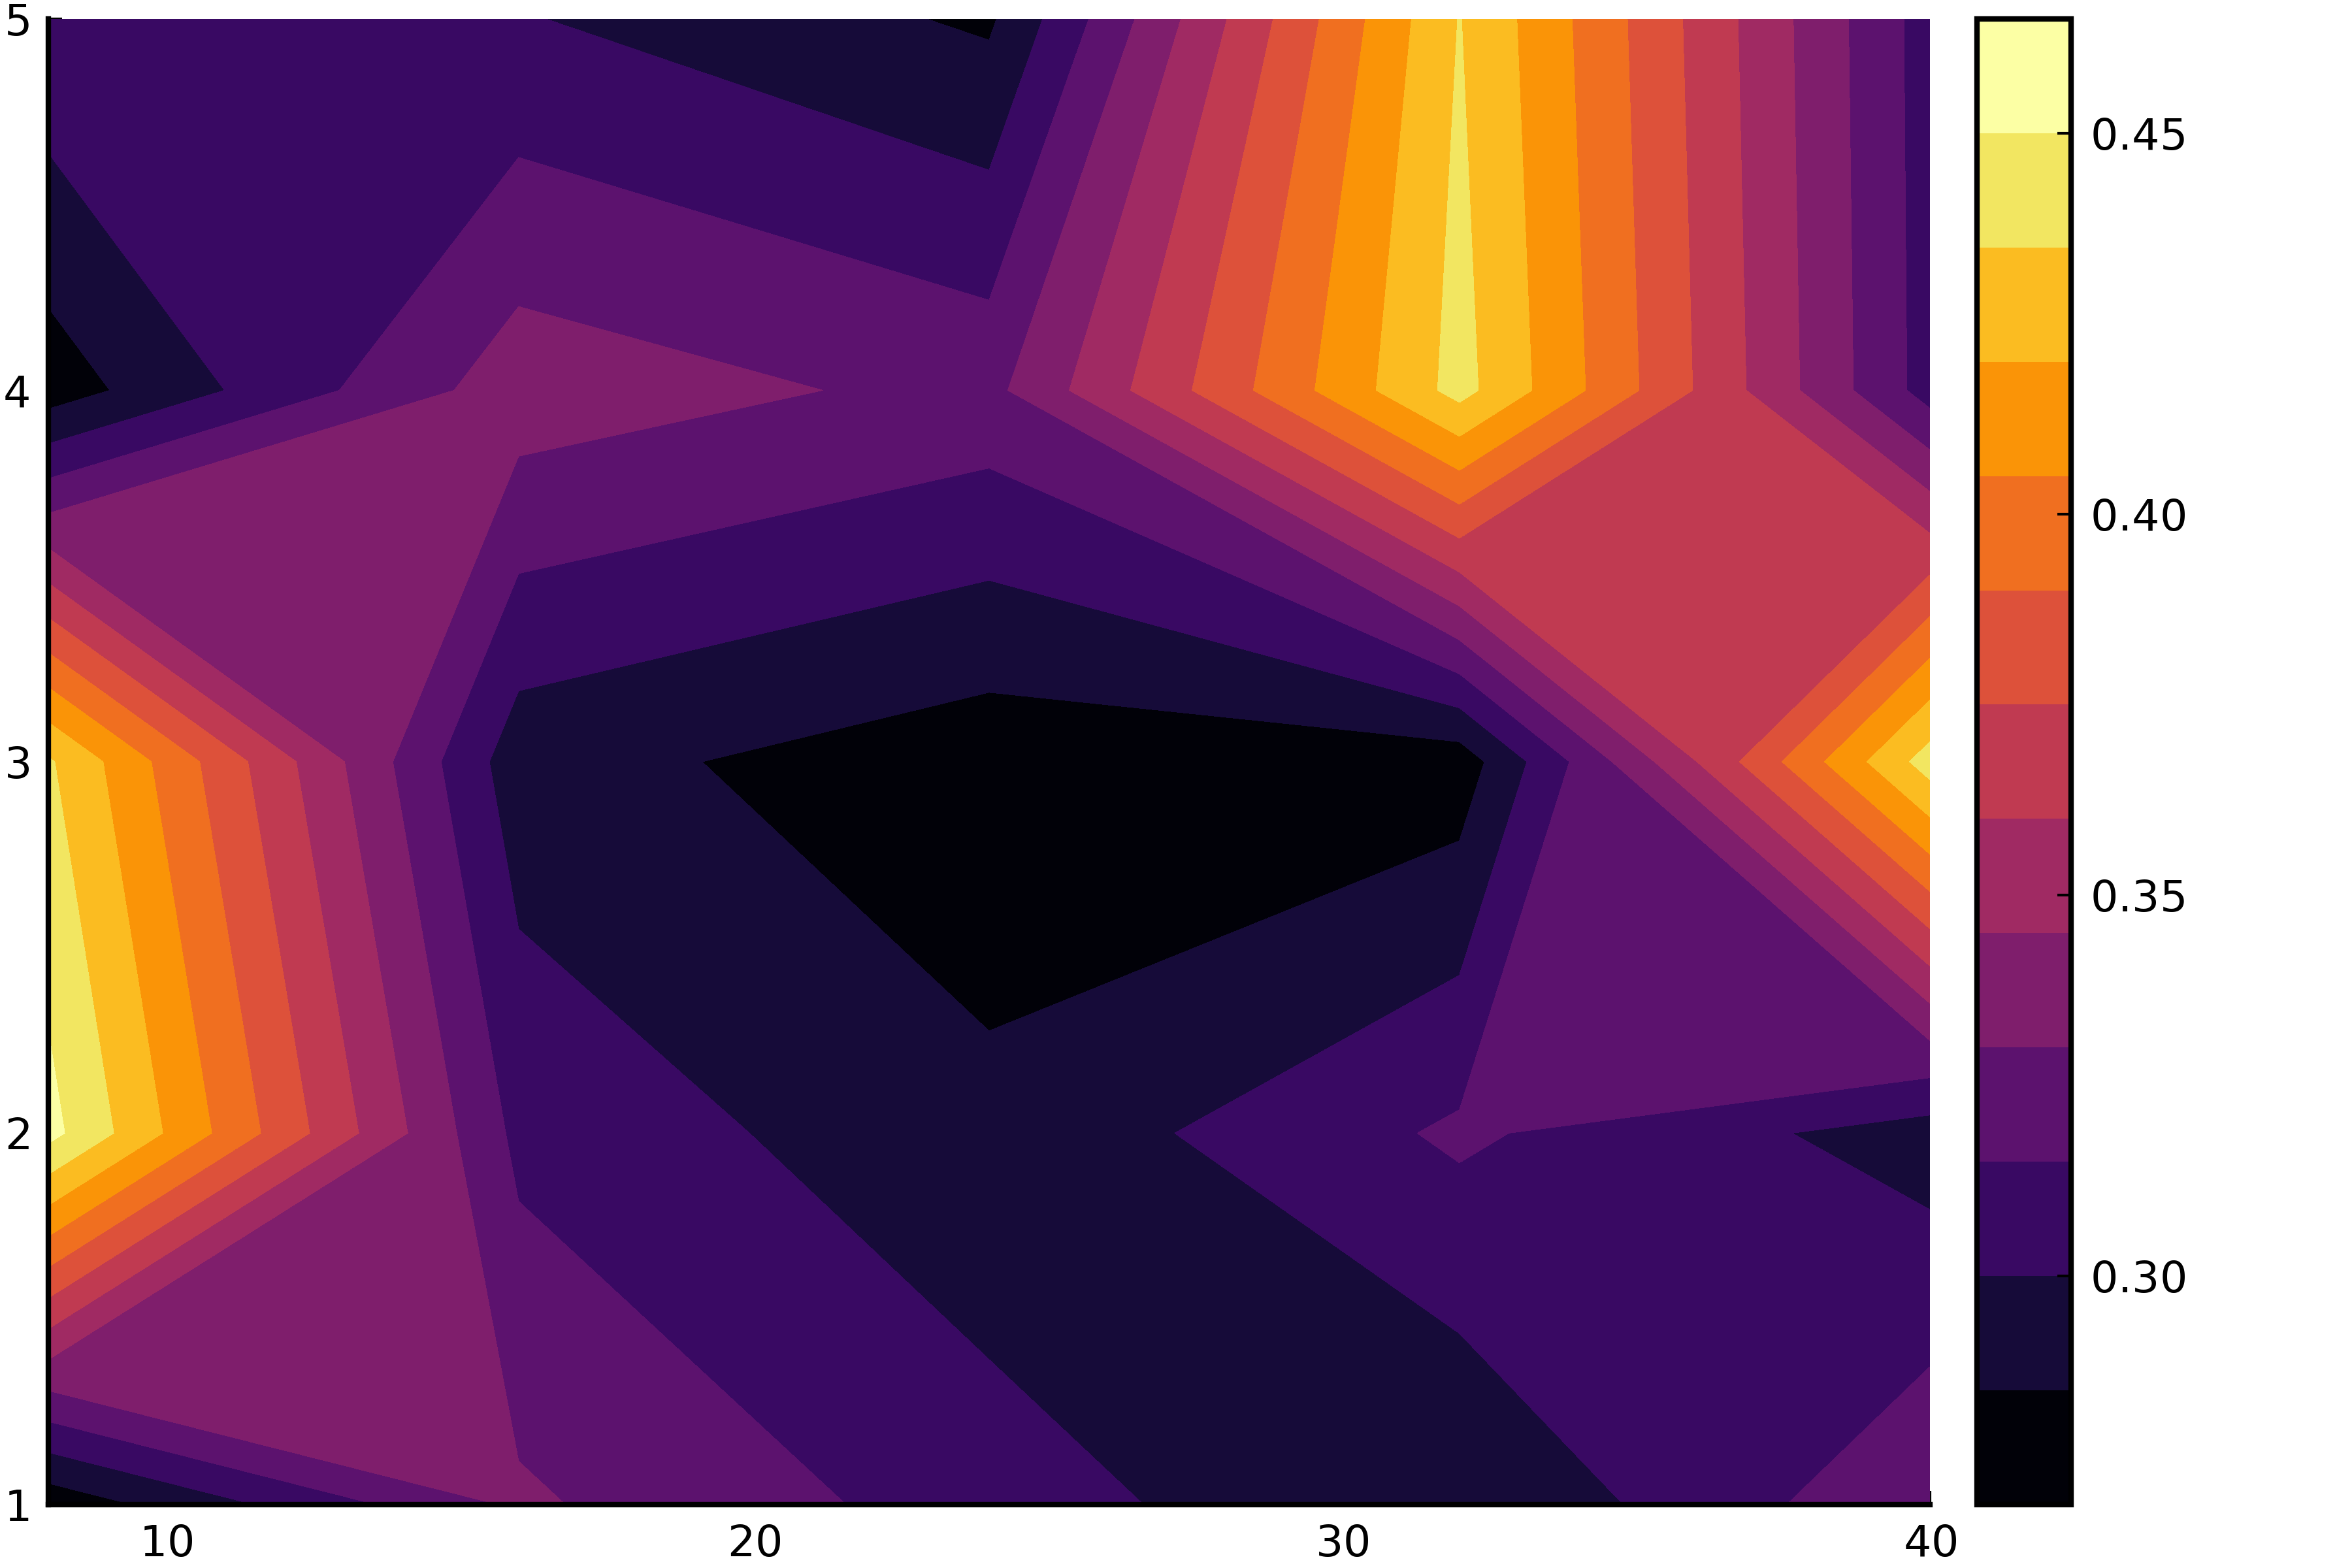

In [32]:
plot(contourf(x, y, (x, y) -> f(x, y, d_val_15noise)), dpi=600)

## Check results

In [4]:
filename = "./src/examples/burgers/models/feedforward4/tuning_burgers_fnn_worker_47_iter_46.bson"
@load filename K p

In [87]:
dataset = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_training_set.jld2")["training_set"];
(train_loader, val_loader) = ProcessingTools.get_data_loader(dataset, 32, 0.7, false, false);
(x, y, z) = first(train_loader);
u0 = x[:, 1];
u = y[:, :, 1];
t = z[1];

In [90]:
u

64×64 Matrix{Float64}:
  0.0       -0.236621   -0.469819   …  -0.223989   -0.221164   -0.218472
 -1.64987   -1.7339     -1.67473       -0.173254   -0.171723   -0.170299
 -1.82192   -1.44589    -1.18393       -0.121481   -0.121793   -0.122156
 -0.330269  -0.21109    -0.146376      -0.0824974  -0.0848083  -0.0870866
  1.77955    1.29097     1.02055       -0.0712854  -0.0750691  -0.0787241
  2.63341    2.39117     2.038      …  -0.0979498  -0.101726   -0.10533
  1.63354    1.94659     2.13398       -0.155591   -0.157546   -0.159409
 -0.155786  -0.133017   -0.0828701     -0.217398   -0.21701    -0.216696
 -1.51389   -1.65718    -1.76589       -0.257599   -0.256221   -0.255037
 -2.12771   -2.13281    -2.06006       -0.272938   -0.272567   -0.272412
 -2.07924   -1.83683    -1.60852    …  -0.280278   -0.28233    -0.284529
 -1.22673   -0.97989    -0.818353      -0.302373   -0.307052   -0.311712
  0.249901   0.173892    0.126708      -0.35348    -0.359278   -0.364833
  ⋮                        

In [96]:
# t, u0, u = Generator.get_burgers_batch(1., 0., pi, 0., 64, 64, 0.04, 2);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), AutoTsit5(Rosenbrock23()), saveat=t);
u_pred = prob_neuralode(u0, p);

In [111]:
using Statistics

function plot_mse_snapshot(ŷ, y, t)
    function e(ŷ, y)
        mean((ŷ .- y) .^ 2)
    end

    mse = []
    for i ∈ 1:t_n
        push!(mse, e(u_pred[:, i], u[:, i]))
    end

    plt = plot(mse, linestyle=:dash, label="t0")
end

plot_mse_snapshot (generic function with 1 method)

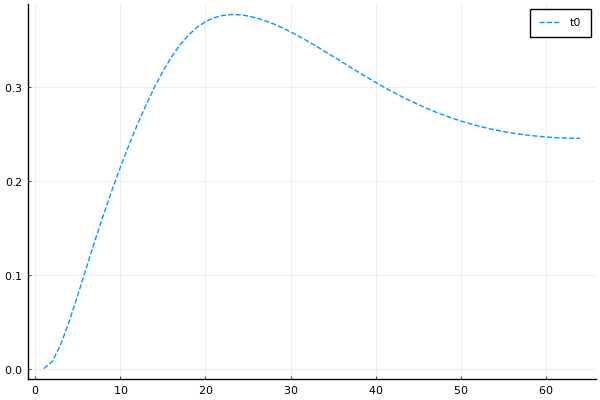

In [112]:
plot_mse_snapshot(u_pred, u, collect(LinRange(0., 1., 64)))

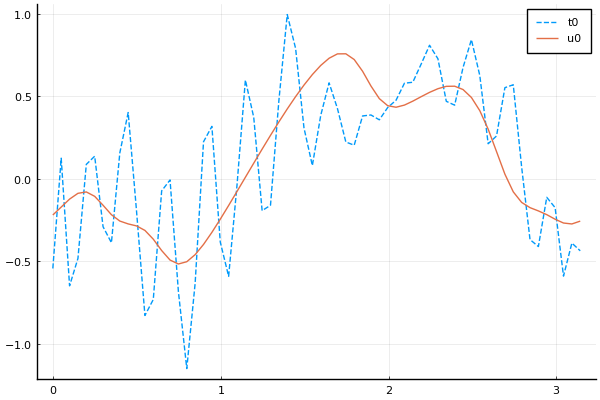

In [97]:
x = collect(LinRange(0., pi, 64));
plt = plot(x, u_pred[:, end], linestyle=:dash, label="t0")
plot!(plt, x, u[:, end], label="u0")

┌ Info: Saved animation to 
│   fn = /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/snapshot_viscous_burgers_nu004_fps15.gif
└ @ Plots /Users/vdesgrange/.julia/packages/Plots/1KWPG/src/animation.jl:114


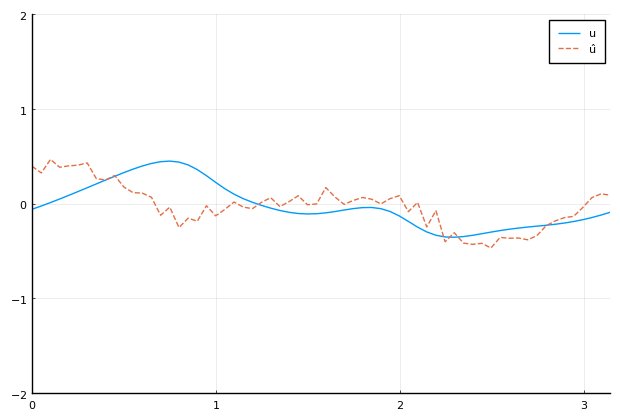

Plots.AnimatedGif("/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/snapshot_viscous_burgers_nu004_fps15.gif")
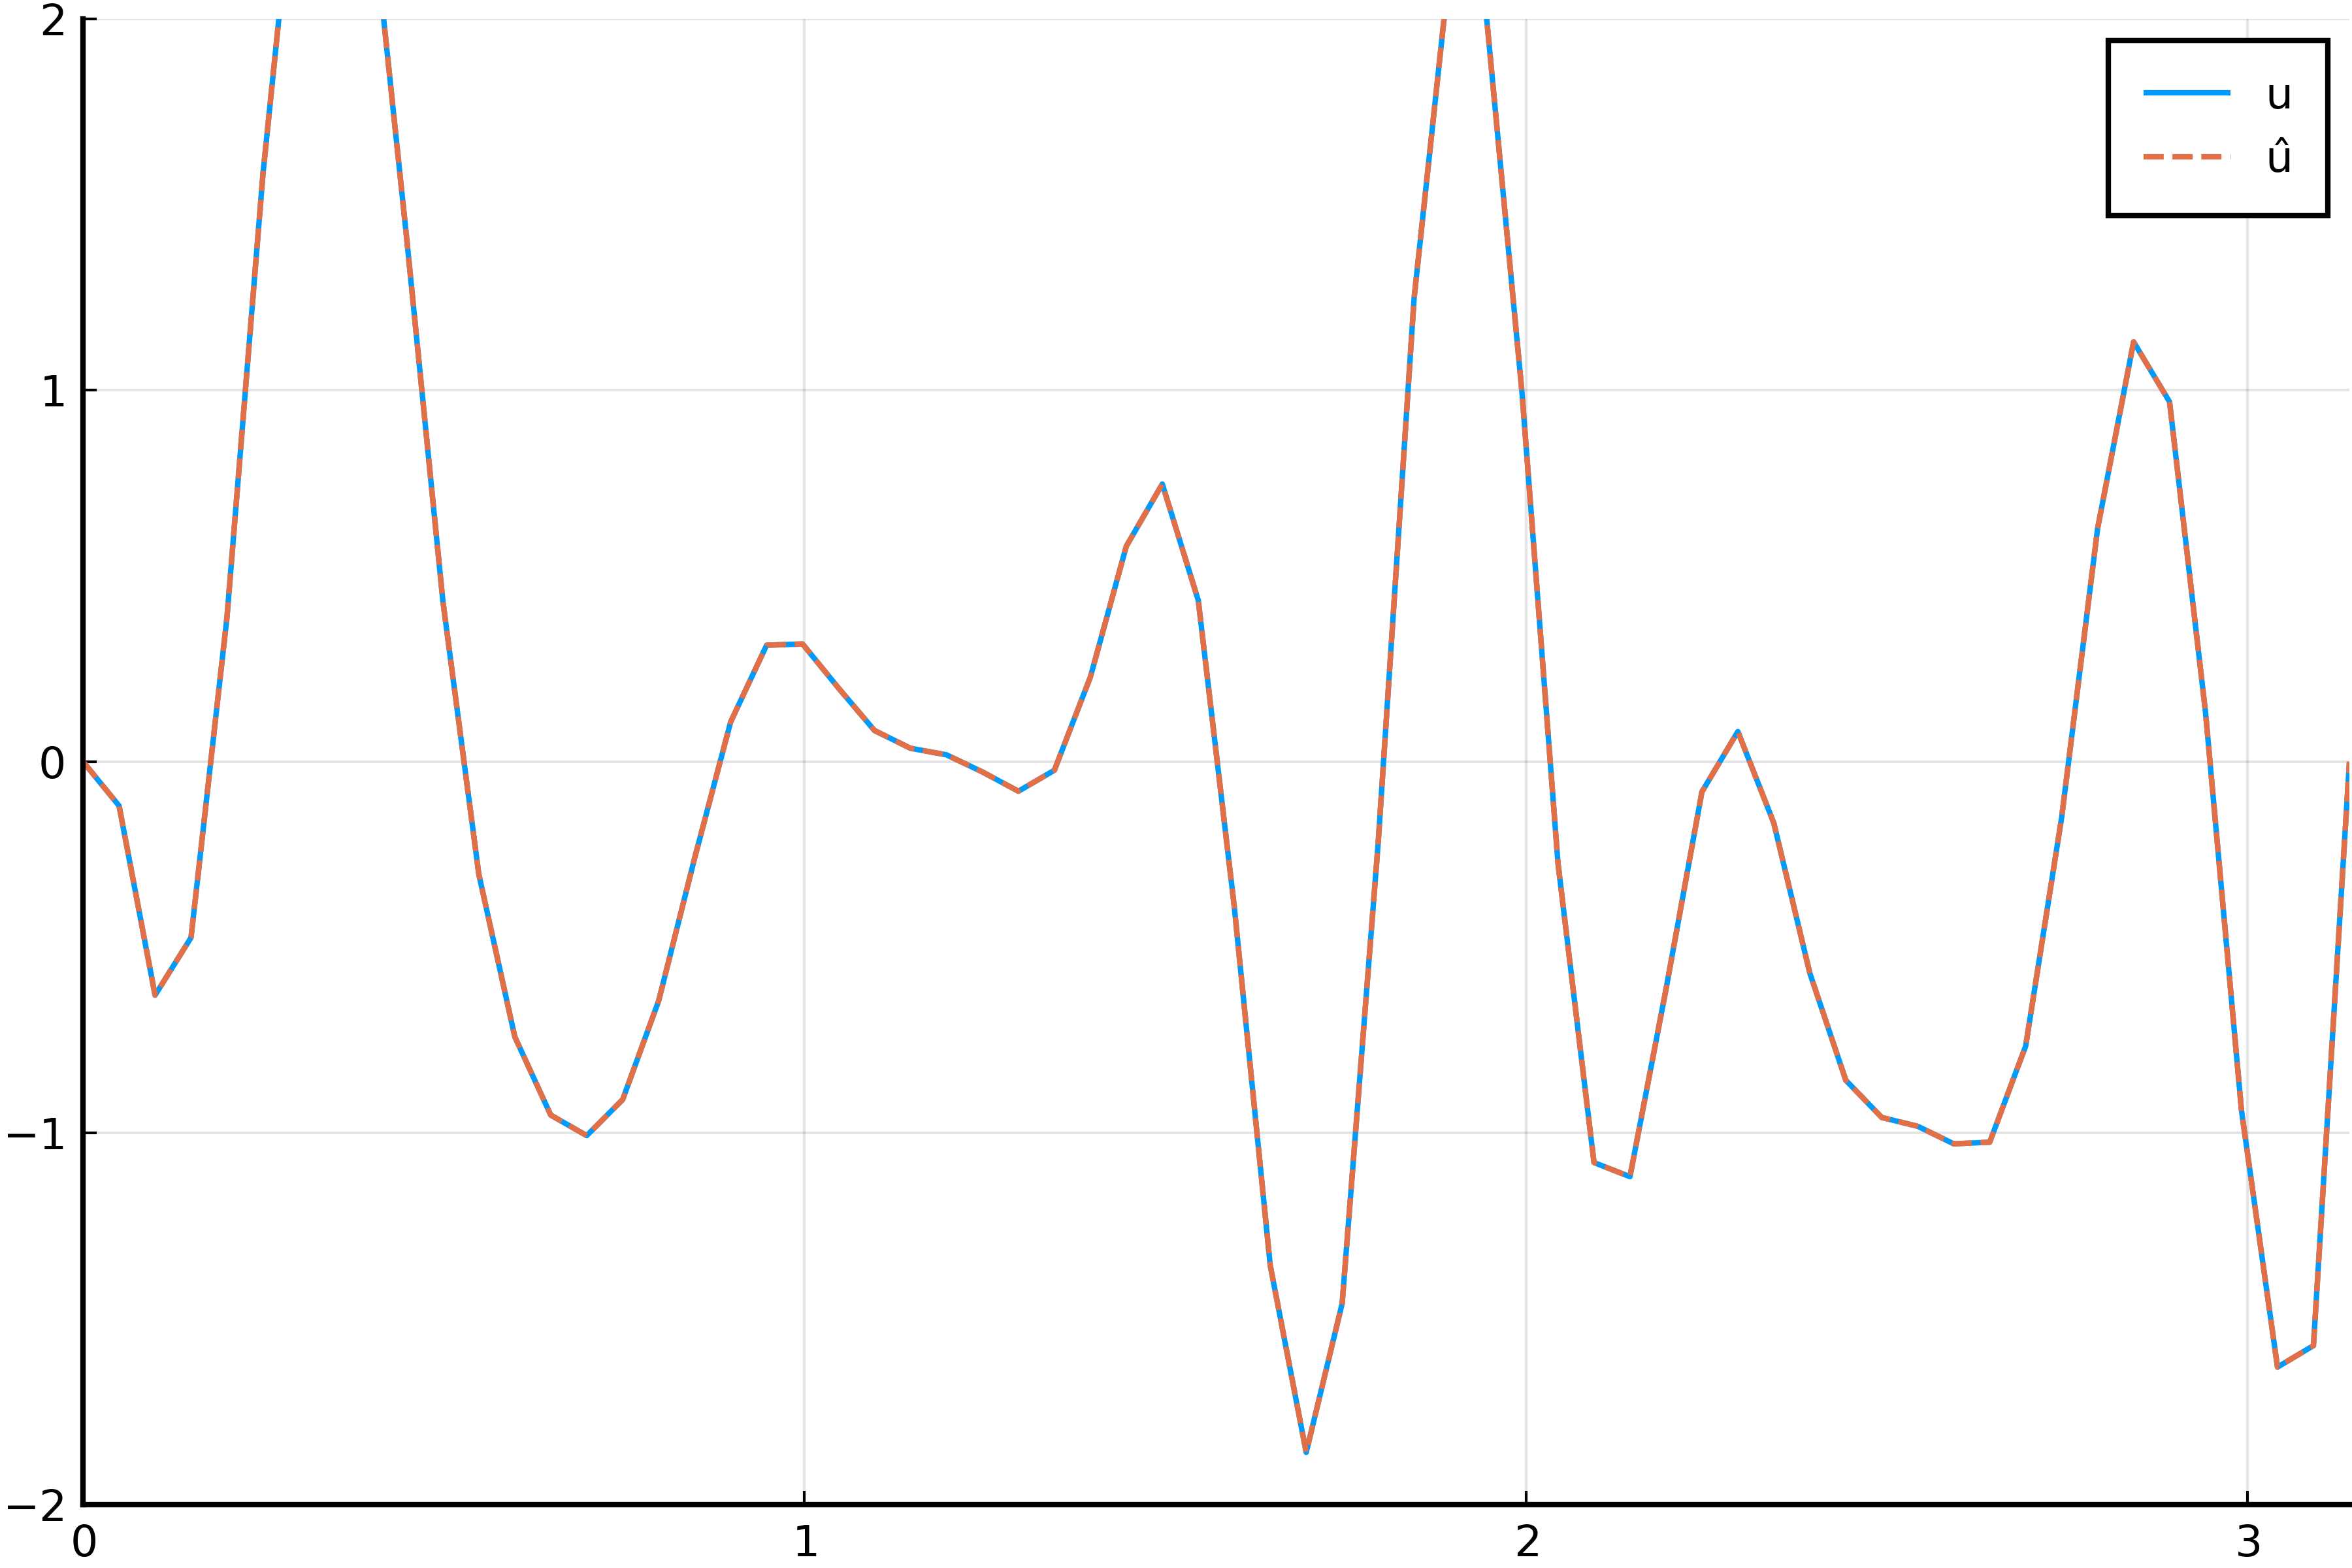

In [45]:
function animate_snapshot_prediction(u_pred, u, x, filename)
    t_n = 64
   
    anim = @animate for i ∈ 1:t_n
        plt = plot(x, u[:, i], label="u")
        plot!(plt, x, u_pred[:, i], linestyle=:dash, label="û")
        plot!(plt; xlims=(0., pi), ylims=(-2, 2.), dpi=600)
    end

    gif(anim, filename, fps = 15)
end

animate_snapshot_prediction(u_pred, u,  x = collect(LinRange(0., pi, 64)), "snapshot_viscous_burgers_nu004_fps15.gif")

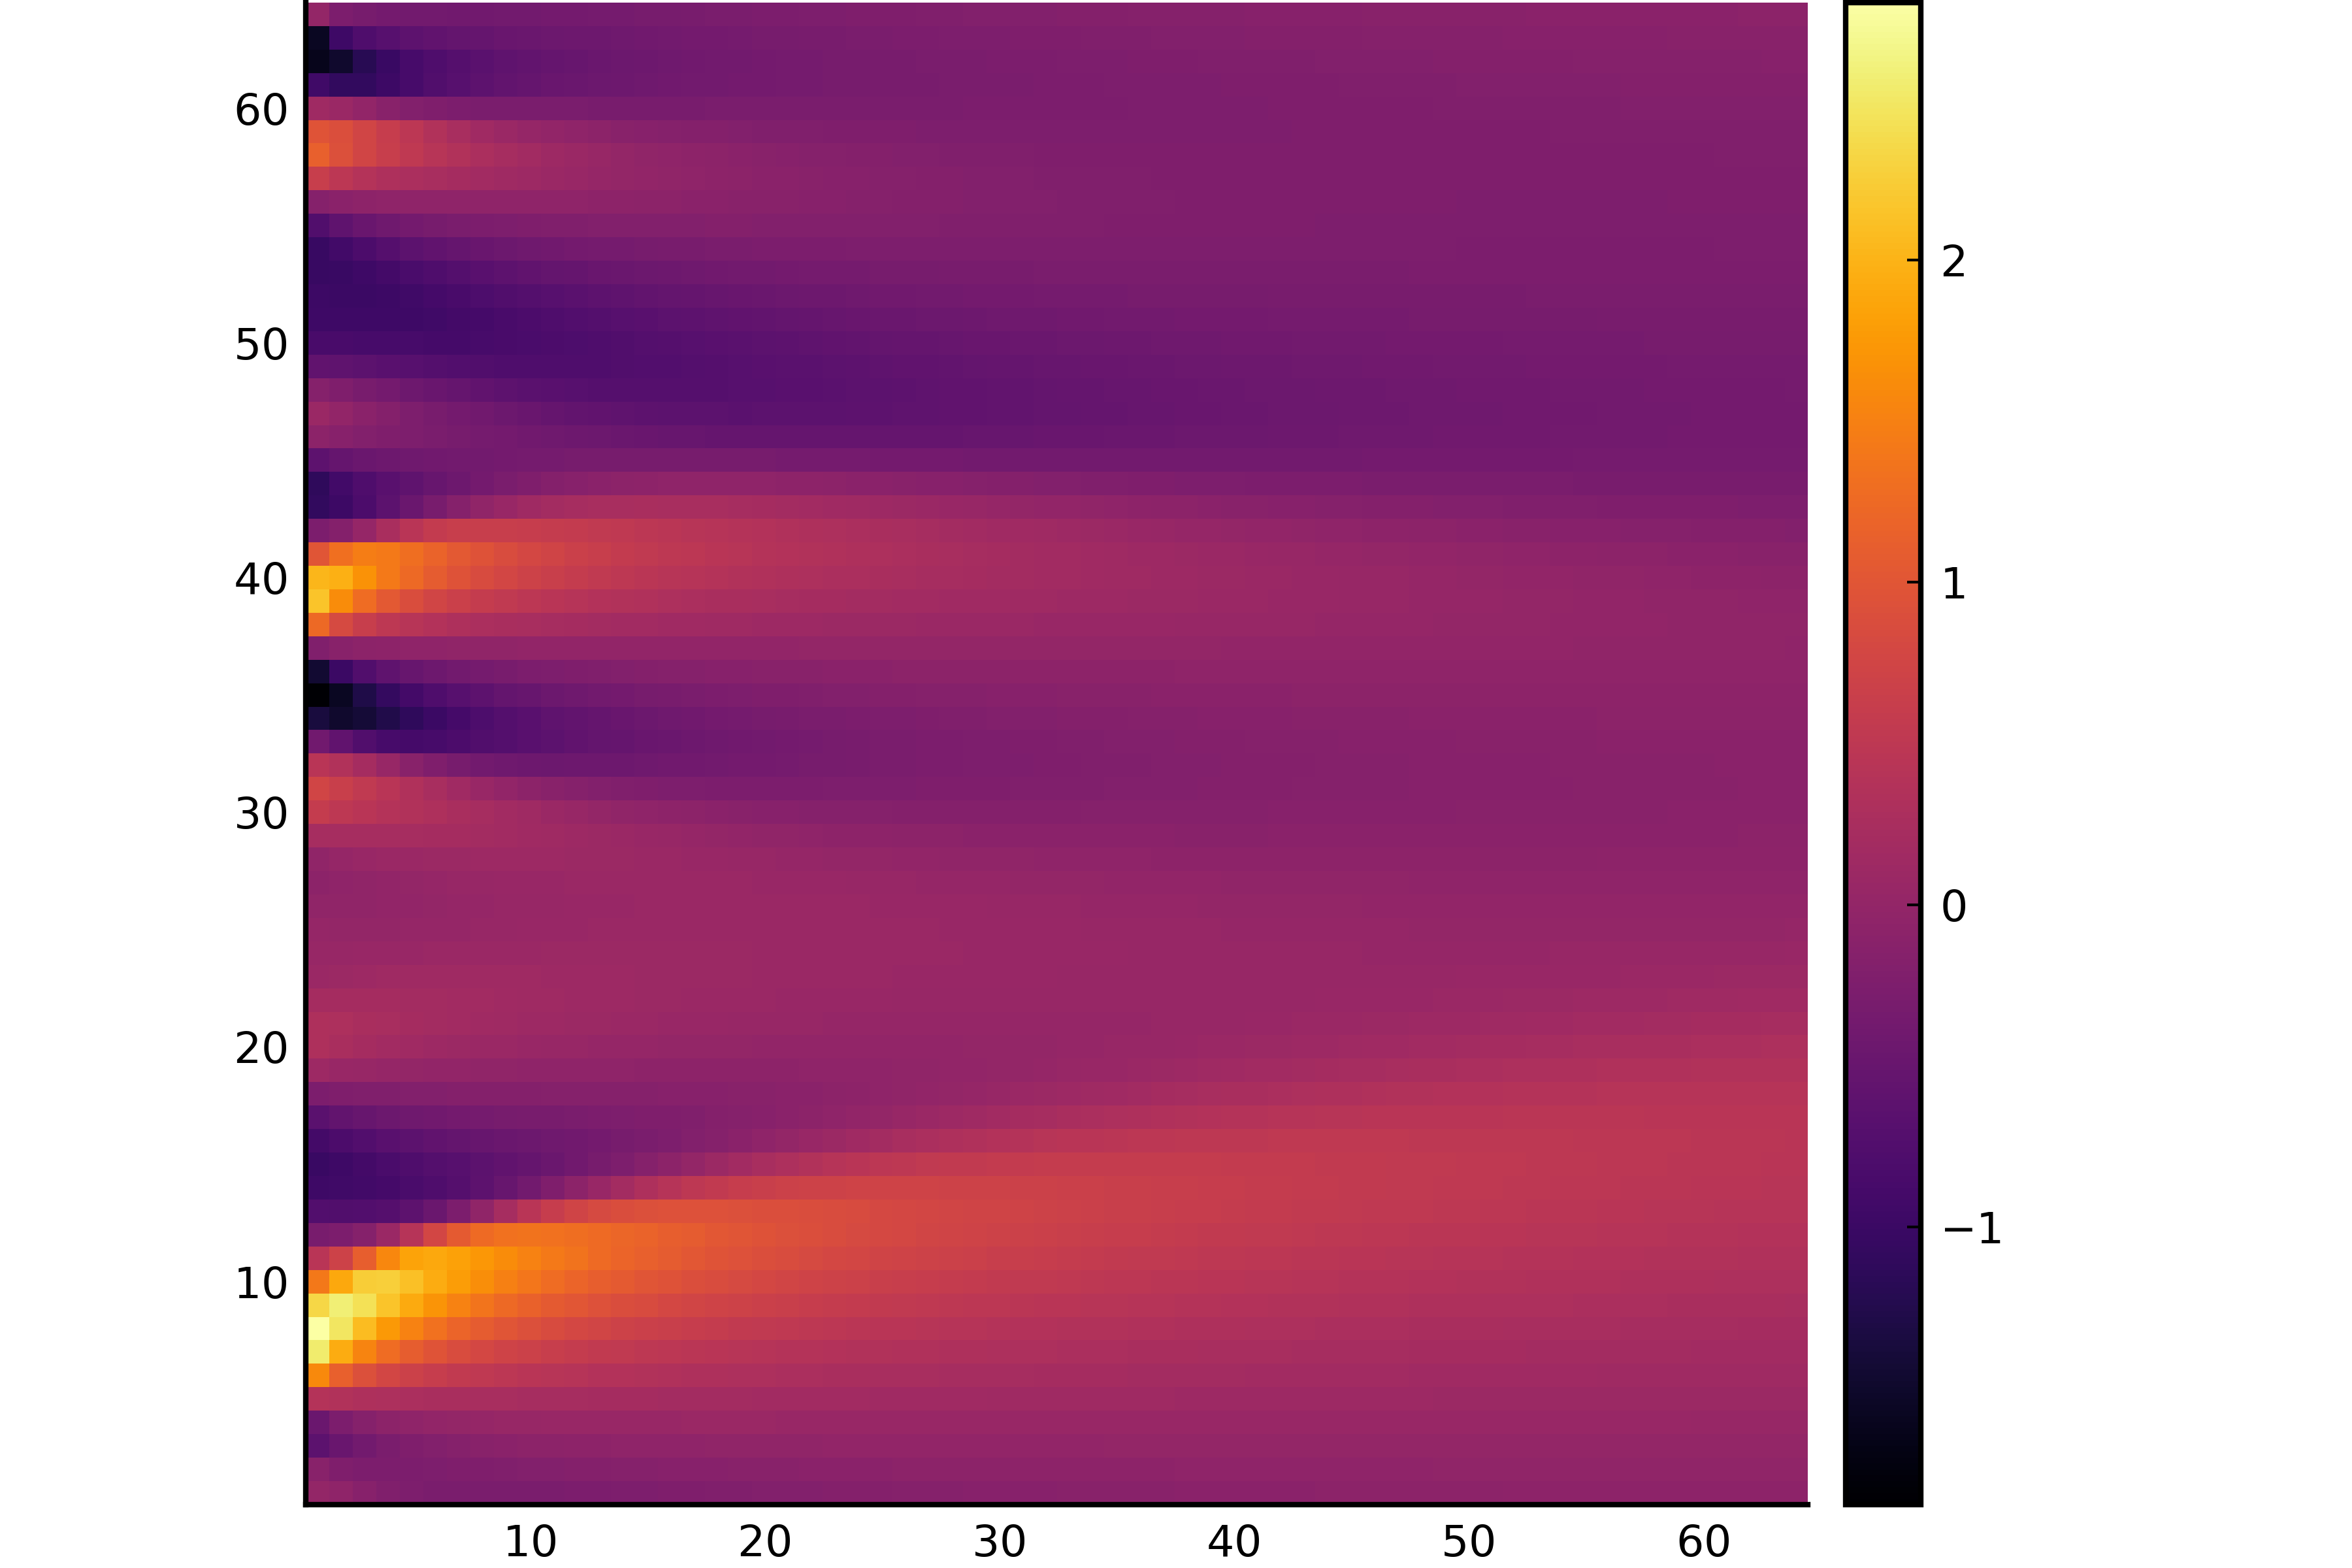

In [6]:
GraphicTools.show_state(u, "")

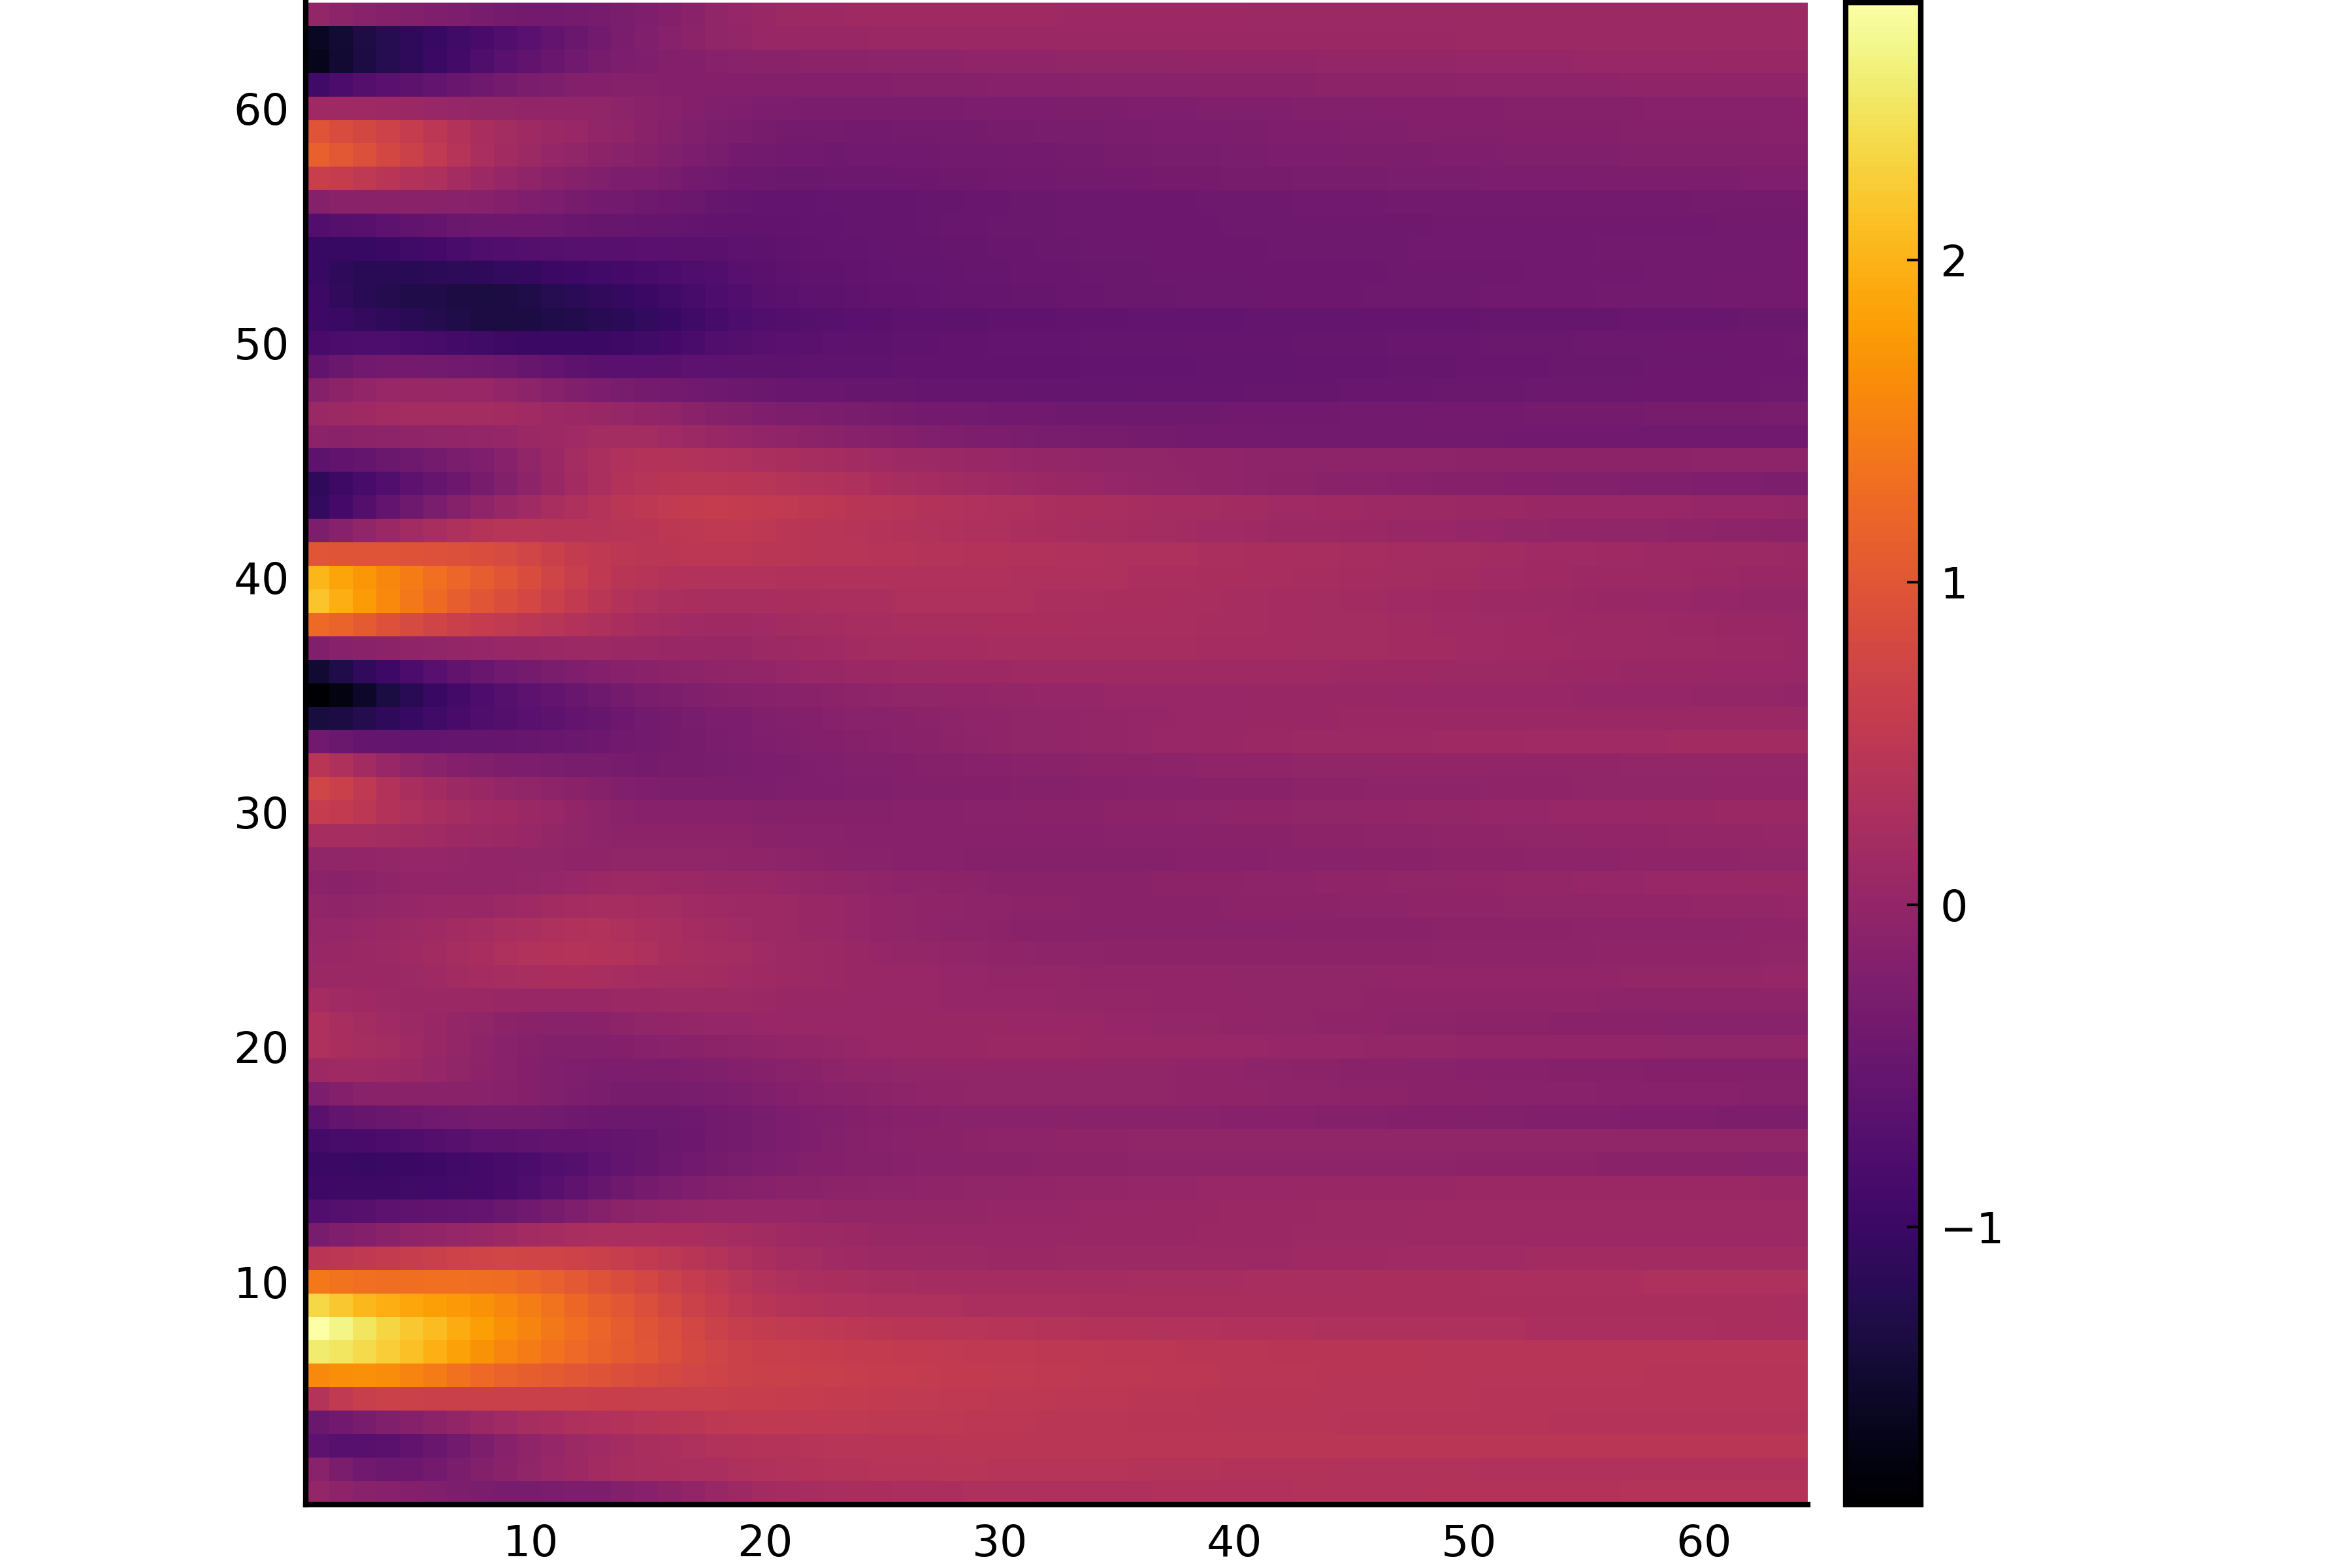

In [7]:
GraphicTools.show_state(hcat(u_pred.u...), "")

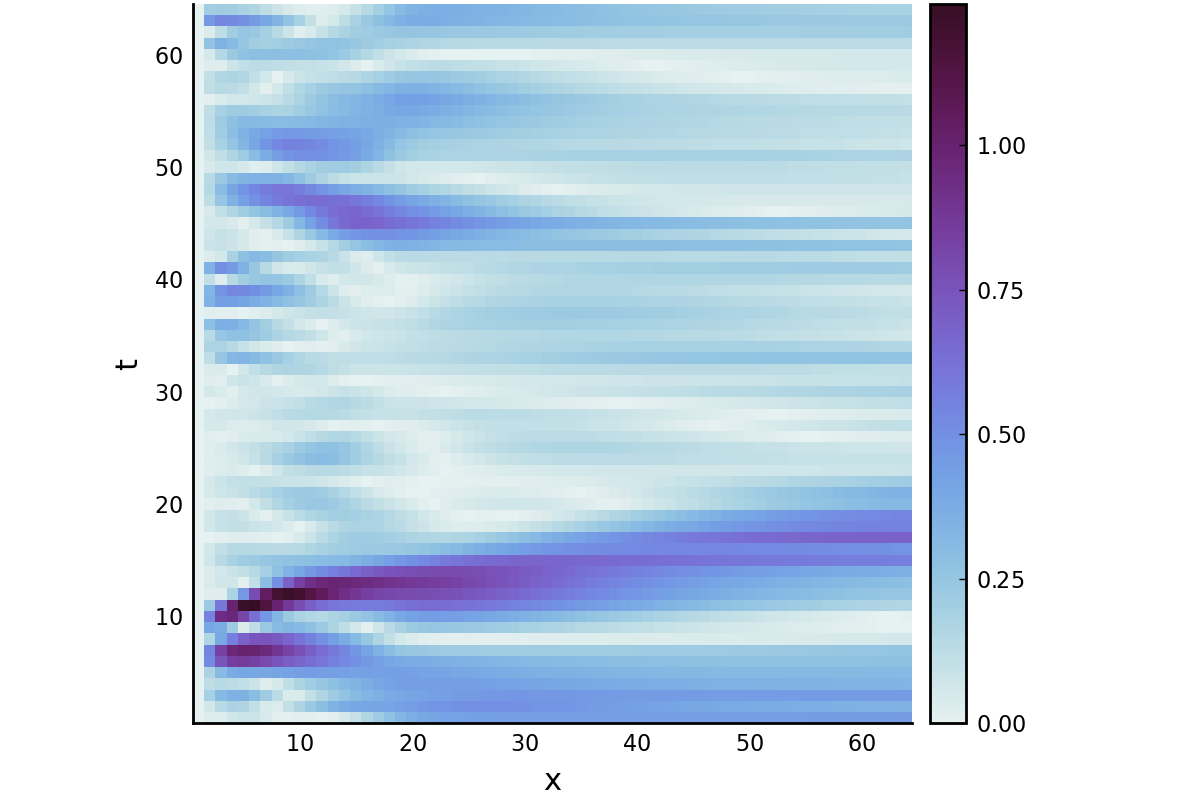

In [8]:
GraphicTools.show_err(hcat(u_pred.u...), u, "")

## Tuning - Regularization

Check the training and validation cost function after training neural network for different $L_2$ regularization parameters. Consider case with Gaussian noise added to prediction.

In [2]:
ho = JLD2.load("./src/examples/burgers/models/feedforward4/hyperopt_result_fnn.jld2")["ho"];

┌ Warning: type Hyperopt.RandomSampler{Random.MersenneTwister} does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:461
┌ Warning: type Hyperopt.Hyperoptimizer{JLD2.ReconstructedTypes.var"##Hyperopt.RandomSampler{Random.MersenneTwister}#334",Main.#1744###hyperopt_objective#411#18} does not exist in workspace; reconstructing
└ @ JLD2 /Users/vdesgrange/.julia/packages/JLD2/k9Gt0/src/data/reconstructing_datatypes.jl:461


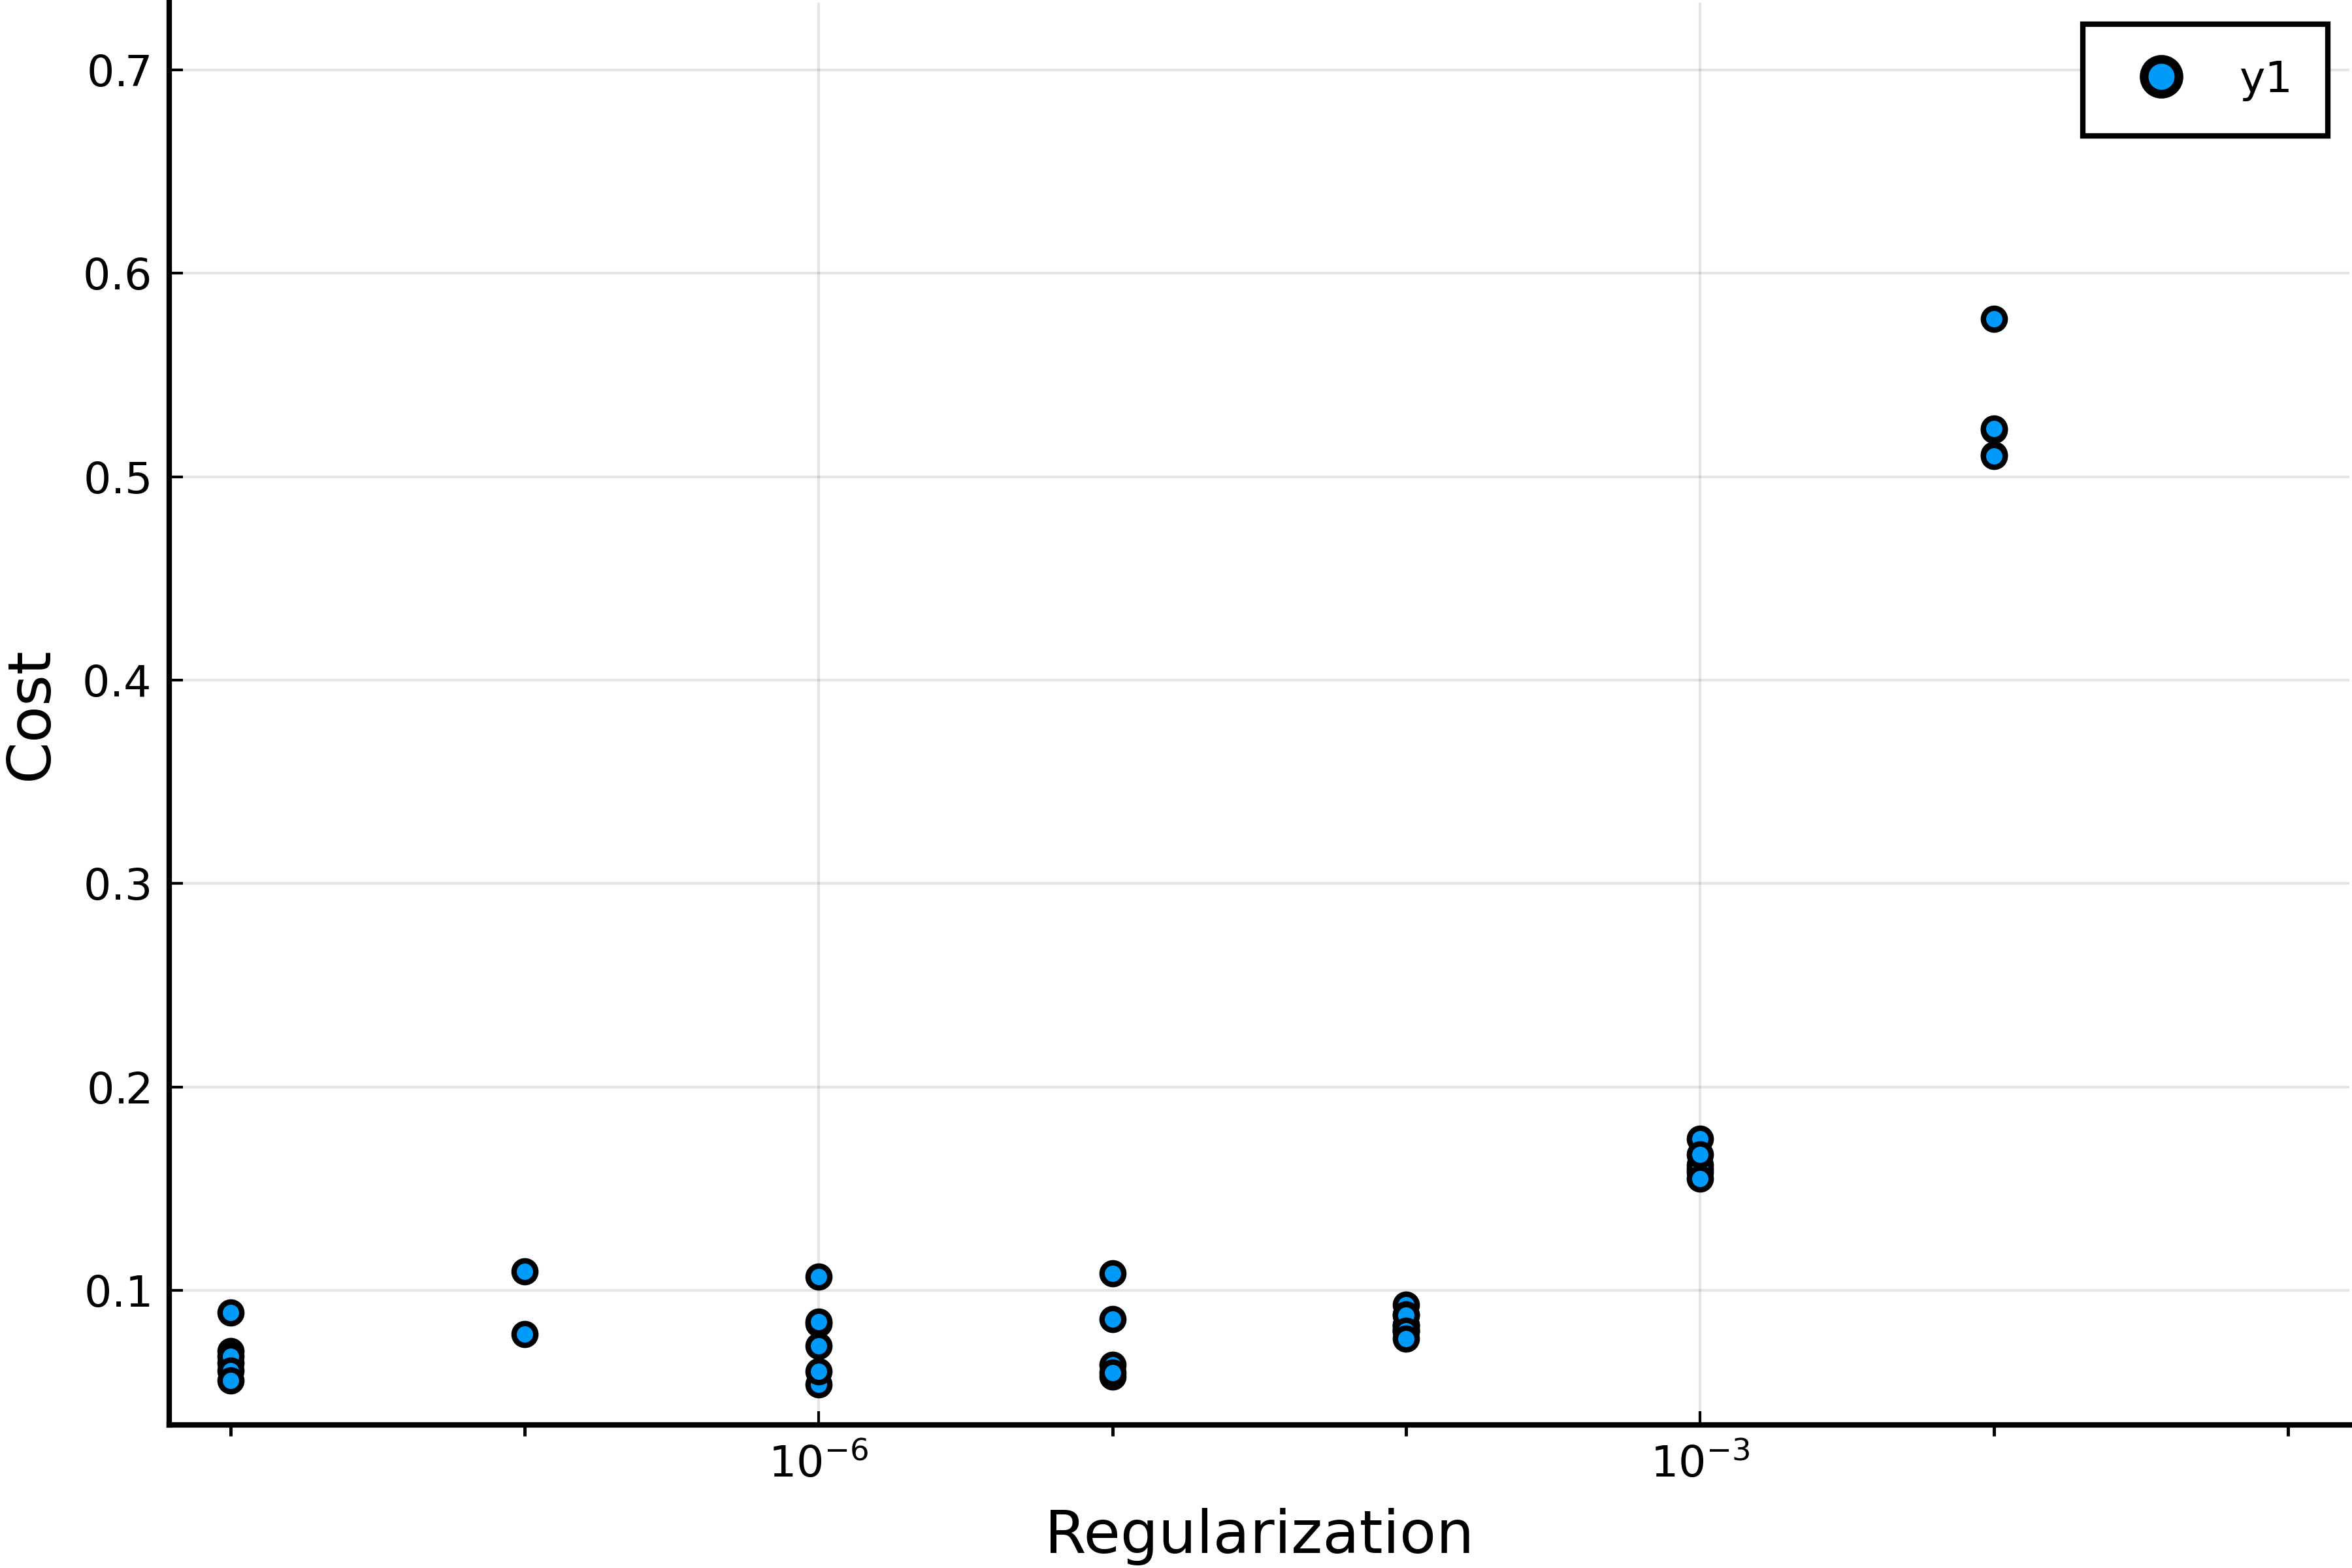

In [20]:
ho.history;

function get_reg(ho)
    x = [];
    y = [];

    for (i, tupl) in enumerate(ho.history)
        push!(x, tupl[3]);
        push!(y, ho.results[i]);
    end
    
    return x, y
end

using BSON

function get_reg_val(ho, dataset, filepath)
    x = [];
    y = [];
    
    (_, val_loader) = ProcessingTools.get_data_loader(dataset, 32, 0.7, false, false);
    
    function val_loss(K, p, x, y, t)
        prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), AutoTsit5(Rosenbrock23()), saveat=t);
        ŷ = prob_neuralode(x, p);
        l = Flux.mse(ŷ, permutedims(y, (1, 3, 2)))
        return l;
    end
    
    function evalcb(K, p, val_loader)
        lval = 0;
        for (x, y, t) in val_loader
            lval += val_loss(K, p, x, y, t[1]);
        end
        lval /= (val_loader.nobs / val_loader.batchsize);
        return lval
    end
    
    for (i, tupl) in enumerate(ho.history)
        filename = filepath * string(i) * ".bson"
        BSON.@load filename K p;
        lval = evalcb(K, p, val_loader);

        push!(x, tupl[3]);
        push!(y, lval);
    end
    
    return x, y
end

x, y = get_reg(ho);
plt = scatter(x, y)
scatter!(plt; dpi=600, xaxis=:log, xlabel="Regularization", ylabel="Cost")


# print(d)

---
### Training 

In [98]:
function main()
  batch_size = 32;
  epochs = 200;
  hl = 3;
  ne = 32;
  reg = 1.0e-6;
  n = 0.01
  lr = 0.03;

  data = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_training_set.jld2")["training_set"];
  model = Models.FeedForwardNetwork(64, hl, ne);
  K, p = BurgersDirect.training(model, epochs, data, batch_size, 0.7, n, reg);
  return K, p
end

K, p = main()

┌ Info: Training on CPU
└ @ Main.BurgersDirect /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/src/examples/burgers/burgers_direct.jl:23
┌ Info: Loading dataset
└ @ Main.BurgersDirect /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/src/examples/burgers/burgers_direct.jl:30
┌ Info: Building model
└ @ Main.BurgersDirect /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/src/examples/burgers/burgers_direct.jl:33
┌ Info: Initiate training
└ @ Main.BurgersDirect /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/src/examples/burgers/burgers_direct.jl:80
┌ Info: Epoch 1
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.6444694979058307
lval = 0.5833667367426252
ltrain = 0.6222778280046909
lval = 0.5689779349171858
ltrain = 0.6043767814023241
lval = 0.5558853244476354


┌ Info: Epoch 2
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.5847906493145734
lval = 0.543900769570317
ltrain = 0.570732277355555
lval = 0.5332601593800763
ltrain = 0.5592197385399869
lval = 0.5233585733607503


┌ Info: Epoch 3
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.5475241693157977
lval = 0.5140036377935339
ltrain = 0.5335855984809973
lval = 0.505239712243908
ltrain = 0.5192086323863817
lval = 0.4968290022632629


┌ Info: Epoch 4
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.5117847971819223
lval = 0.48859171117664024
ltrain = 0.5002848858429654
lval = 0.48057973032866225
ltrain = 0.48620463108295664
lval = 0.47293737961814886


┌ Info: Epoch 5
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.4761373302819976
lval = 0.46558456558834055
ltrain = 0.4668196179814973
lval = 0.4583968281304691
ltrain = 0.45479547173721785
lval = 0.4513044681140088


┌ Info: Epoch 6
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.4448352156235283
lval = 0.44433967672098484
ltrain = 0.4346862605760978
lval = 0.4376348100242115
ltrain = 0.42606225701153605
lval = 0.43098052549325905


┌ Info: Epoch 7
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.41640671073956426
lval = 0.42450998838800985
ltrain = 0.4083034930132445
lval = 0.4182095398731358
ltrain = 0.3986418774924105
lval = 0.4119271565139827


┌ Info: Epoch 8
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.39155790985443606
lval = 0.40587709311128334
ltrain = 0.3839748126639145
lval = 0.39979636503934124
ltrain = 0.3729660875429773
lval = 0.3939291809581438


┌ Info: Epoch 9
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3670413331691585
lval = 0.38820092057270233
ltrain = 0.3599444320496501
lval = 0.38254908054142783
ltrain = 0.35357367879509716
lval = 0.37710657763156447


┌ Info: Epoch 10
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.344714675557364
lval = 0.37171885231545204
ltrain = 0.3383195779163413
lval = 0.36650362860010083
ltrain = 0.33517313160305884
lval = 0.361511291302194


┌ Info: Epoch 11
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.32575641172034925
lval = 0.3567216636479818
ltrain = 0.31882215470485253
lval = 0.35206061369188
ltrain = 0.3128655920194183
lval = 0.34745910306778


┌ Info: Epoch 12
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.30581813413168313
lval = 0.34304161507219494
ltrain = 0.2999780879134862
lval = 0.3387167014226919
ltrain = 0.29685085316641735
lval = 0.3344966601967025


┌ Info: Epoch 13
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.29171079512734377
lval = 0.33037197617824465
ltrain = 0.2866494513655127
lval = 0.3264134614942909
ltrain = 0.2803776939878261
lval = 0.32255303672374636


┌ Info: Epoch 14
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.27583477354478814
lval = 0.3187573167457277
ltrain = 0.27148748392662114
lval = 0.31505026758294685
ltrain = 0.265476739875354
lval = 0.31154022643487567


┌ Info: Epoch 15
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2618492414387675
lval = 0.30810092921592797
ltrain = 0.25820474237347474
lval = 0.30474722928937936
ltrain = 0.25279898707208776
lval = 0.301499241921703


┌ Info: Epoch 16
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.24676300582393396
lval = 0.29825384553435236
ltrain = 0.24550450040385768
lval = 0.2951088939493163
ltrain = 0.23947393126711766
lval = 0.29210119329110074


┌ Info: Epoch 17
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.23653484954905216
lval = 0.28911024571235117
ltrain = 0.23091858870273343
lval = 0.28623780085443756
ltrain = 0.22841610670955137
lval = 0.2833904134233562


┌ Info: Epoch 18
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.22367194359381648
lval = 0.28057708916025637
ltrain = 0.2208401572710249
lval = 0.27787135516023737
ltrain = 0.21877514480441992
lval = 0.2751346102959246


┌ Info: Epoch 19
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.21479147928076317
lval = 0.27243500191866665
ltrain = 0.21466430172713735
lval = 0.2697938589395684
ltrain = 0.20887154451011108
lval = 0.267158798587652


┌ Info: Epoch 20
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.20597490637449234
lval = 0.26459165115584
ltrain = 0.20358453067020418
lval = 0.26197960828414724
ltrain = 0.20099130299344073
lval = 0.25944179756185215


┌ Info: Epoch 21
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.19787334558128625
lval = 0.2570112410559858
ltrain = 0.19432087434922682
lval = 0.2545324519060566
ltrain = 0.18875330749603556
lval = 0.2520614172981565


┌ Info: Epoch 22
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.19009942159987353
lval = 0.24963987200825113
ltrain = 0.1855533363996529
lval = 0.24724712964788884
ltrain = 0.18395879672433915
lval = 0.2448437367278714


┌ Info: Epoch 23
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.18032201803026343
lval = 0.24243045046445688
ltrain = 0.17982276460636867
lval = 0.24006516338090608
ltrain = 0.17627404530581592
lval = 0.23776231205338869


┌ Info: Epoch 24
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1750130699170005
lval = 0.23549337822792485
ltrain = 0.16940842521712804
lval = 0.2332215076692171
ltrain = 0.16960265658660453
lval = 0.23103685382853004


┌ Info: Epoch 25
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.16620598622000177
lval = 0.22887934801031376
ltrain = 0.16422088103740065
lval = 0.2267806117982147
ltrain = 0.16153241608372393
lval = 0.22468617737832683


┌ Info: Epoch 26
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.15903899644645236
lval = 0.22262213386869725
ltrain = 0.1575019578162372
lval = 0.22061085348192147
ltrain = 0.15524009920170864
lval = 0.21860264524355222


┌ Info: Epoch 27
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.15331422154857605
lval = 0.2166742385402303
ltrain = 0.1516256030041683
lval = 0.2147506096373423
ltrain = 0.14844602081433755
lval = 0.2128167984034205


┌ Info: Epoch 28
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.148287015685721
lval = 0.21092356216040306
ltrain = 0.1447823086509009
lval = 0.20905797645503274
ltrain = 0.1436724874570902
lval = 0.20720481493981863


┌ Info: Epoch 29
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.14195040633116457
lval = 0.205360385833316
ltrain = 0.1394519613621447
lval = 0.20356122913106822
ltrain = 0.13978010442590277
lval = 0.2018177071241155


┌ Info: Epoch 30
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13565246587564883
lval = 0.20007778143297186
ltrain = 0.1340531150311916
lval = 0.19840772627169098
ltrain = 0.13347939291722427
lval = 0.19676352458511148


┌ Info: Epoch 31
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13255947540786003
lval = 0.1951284259373434
ltrain = 0.13082941333759585
lval = 0.19347587842288227
ltrain = 0.12913515223556968
lval = 0.1919396243879071


┌ Info: Epoch 32
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1277508752878172
lval = 0.1904197275256988
ltrain = 0.12523864958722097
lval = 0.18896669776238012
ltrain = 0.12317093607202925
lval = 0.18748997813319696


┌ Info: Epoch 33
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12253914714213489
lval = 0.18595189569656237
ltrain = 0.12094104151573228
lval = 0.18444037175796218
ltrain = 0.12008407844492495
lval = 0.18307644592051145


┌ Info: Epoch 34
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11926019176692237
lval = 0.18169577766584744
ltrain = 0.1177909099455013
lval = 0.18039542342219994
ltrain = 0.11675667918917683
lval = 0.1790925805763006


┌ Info: Epoch 35
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11519591353955612
lval = 0.1777328882833642
ltrain = 0.11408705928463839
lval = 0.17642466634482454
ltrain = 0.11244723264977696
lval = 0.17520432296176933


┌ Info: Epoch 36
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11138891088986169
lval = 0.17400207177216345
ltrain = 0.11169041215535468
lval = 0.17284372081892418
ltrain = 0.1095922122426573
lval = 0.17165102675716448


┌ Info: Epoch 37
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10969156782194346
lval = 0.17046896049312457
ltrain = 0.10795811776934253
lval = 0.16928746420592877
ltrain = 0.1063868495977937
lval = 0.16813790033931478


┌ Info: Epoch 38
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10648120033843807
lval = 0.16696137711215794
ltrain = 0.10404858105165186
lval = 0.16586107525358917
ltrain = 0.1036533683272449
lval = 0.16475742115500489


┌ Info: Epoch 39
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10230163531544909
lval = 0.16374655441432504
ltrain = 0.10172761421304509
lval = 0.16276207205903362
ltrain = 0.10084036227187523
lval = 0.16166711659087313


┌ Info: Epoch 40
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10021201067767307
lval = 0.1605917454316199
ltrain = 0.09860113187918534
lval = 0.15954846881423268
ltrain = 0.09812583844351724
lval = 0.15851126230879106


┌ Info: Epoch 41
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09718793069805116
lval = 0.15754692335083417
ltrain = 0.0960346987198069
lval = 0.1566232974498271
ltrain = 0.0955614783013107
lval = 0.15564114002767784


┌ Info: Epoch 42
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09448764625336535
lval = 0.15462142315236452
ltrain = 0.09412705431508717
lval = 0.15373880685034508
ltrain = 0.09357726128589479
lval = 0.15285274129305493


┌ Info: Epoch 43
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09294346708324858
lval = 0.1520332813803688
ltrain = 0.09117961668279886
lval = 0.15122583364992512
ltrain = 0.09124575734108148
lval = 0.150408449424334


┌ Info: Epoch 44
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09062678881668236
lval = 0.14961749778861186
ltrain = 0.09070706126963082
lval = 0.14889852671801165
ltrain = 0.08919333100595098
lval = 0.14812076132522947


┌ Info: Epoch 45
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08822315859942229
lval = 0.14733608131679765
ltrain = 0.08768488366641063
lval = 0.14658284774088845
ltrain = 0.08713414052242738
lval = 0.1458772364131425


┌ Info: Epoch 46
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08664968920340702
lval = 0.1451816890432819
ltrain = 0.08544386136611919
lval = 0.14452884787741638
ltrain = 0.08487821476944954
lval = 0.14387016994611357


┌ Info: Epoch 47
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08529016186636904
lval = 0.14319509662410249
ltrain = 0.08392581507648023
lval = 0.1425772446654653
ltrain = 0.08299922291403625
lval = 0.14195124564770198


┌ Info: Epoch 48
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08258868453753912
lval = 0.14127263080011518
ltrain = 0.08227464359065739
lval = 0.14071532117107555
ltrain = 0.08198621754304707
lval = 0.1401293871977701


┌ Info: Epoch 49
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0809852501079287
lval = 0.13954150878323848
ltrain = 0.08123800098637886
lval = 0.13897684516852965
ltrain = 0.08026439894258919
lval = 0.13843455645808203


┌ Info: Epoch 50
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0793704037204065
lval = 0.13785155408657349
ltrain = 0.07922975546062944
lval = 0.13731658317234596
ltrain = 0.07873206328798735
lval = 0.1368038145734718


┌ Info: Epoch 51
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07802586446493913
lval = 0.1363261130758278
ltrain = 0.07760121307283416
lval = 0.13590218884066926
ltrain = 0.07771457612123812
lval = 0.13535891380730417


┌ Info: Epoch 52
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07685919447017267
lval = 0.1348265607792814
ltrain = 0.07668431886595385
lval = 0.13429991906482916
ltrain = 0.07562839612739367
lval = 0.1338039717008035


┌ Info: Epoch 53
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0753544307274756
lval = 0.13338000141423986
ltrain = 0.07513454793951344
lval = 0.1329782578304493
ltrain = 0.07478938809102026
lval = 0.1325174114657821


┌ Info: Epoch 54
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07384626569430254
lval = 0.13207130169889367
ltrain = 0.0747245435685923
lval = 0.131668532654893
ltrain = 0.07383809097498872
lval = 0.13122602851226767


┌ Info: Epoch 55
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07345616667620637
lval = 0.13079236764602595
ltrain = 0.0724293515118607
lval = 0.13034013124038688
ltrain = 0.07222570010408952
lval = 0.12994100445304121


┌ Info: Epoch 56
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07121553782841072
lval = 0.12948143266252943
ltrain = 0.07151864049205806
lval = 0.1290937410189372
ltrain = 0.07104152640452759
lval = 0.12874965846237213


┌ Info: Epoch 57
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07072075197692344
lval = 0.12845172878686745
ltrain = 0.07028105375468291
lval = 0.12805612736309685
ltrain = 0.07024290088367187
lval = 0.12772077528737058


┌ Info: Epoch 58
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0698347360431855
lval = 0.12743103293507196
ltrain = 0.06940287709034364
lval = 0.1271572328186185
ltrain = 0.06852919003285035
lval = 0.12677372640083065


┌ Info: Epoch 59
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06808872653685037
lval = 0.12638297056389347
ltrain = 0.06796825392350365
lval = 0.12601547616690723
ltrain = 0.06762084857971919
lval = 0.1256404965678017


┌ Info: Epoch 60
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06751646226017932
lval = 0.12524494507948605
ltrain = 0.06770985820115617
lval = 0.1248988825967504
ltrain = 0.06729224649645144
lval = 0.1245429621112329


┌ Info: Epoch 61
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06634386636534247
lval = 0.12412009264376951
ltrain = 0.06616897978649534
lval = 0.12386232824825666
ltrain = 0.06643877079389514
lval = 0.1235593385067311


┌ Info: Epoch 62
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06544893675649731
lval = 0.12323935159021719
ltrain = 0.0649521348098708
lval = 0.1230137336624654
ltrain = 0.06533463323789791
lval = 0.12273696471946394


┌ Info: Epoch 63
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06525362483785804
lval = 0.12247367493964427
ltrain = 0.06434479734792904
lval = 0.12225414942690262
ltrain = 0.06422390190501213
lval = 0.12196256395394228


┌ Info: Epoch 64
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06409161081882596
lval = 0.12165327371103919
ltrain = 0.06377204850996436
lval = 0.12143135170851634
ltrain = 0.0636256636172182
lval = 0.1211326967812675


┌ Info: Epoch 65
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06363615677404431
lval = 0.1207541395236992
ltrain = 0.06336378053670472
lval = 0.12058198048392203
ltrain = 0.0622690197525119
lval = 0.12031873342364678


┌ Info: Epoch 66
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0626414587740347
lval = 0.11998997406802932
ltrain = 0.06220047081228329
lval = 0.11968517760441912
ltrain = 0.061717763201728136
lval = 0.11951758956307672


┌ Info: Epoch 67
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.061558234677409174
lval = 0.11934225500007045
ltrain = 0.06250924764811629
lval = 0.1191512271738831
ltrain = 0.061086159752051825
lval = 0.1190212437578123


┌ Info: Epoch 68
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.061098691025145306
lval = 0.11882487907934143
ltrain = 0.06059247168750154
lval = 0.11869903126320223
ltrain = 0.060776771230967794
lval = 0.11844778488159773


┌ Info: Epoch 69
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06009004805722458
lval = 0.11805089398392385
ltrain = 0.06014102458605666
lval = 0.11779699598401465
ltrain = 0.059739251894691967
lval = 0.11759966185093432


┌ Info: Epoch 70
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05947396658702483
lval = 0.11742614124289619
ltrain = 0.06004479128934938
lval = 0.1173540653647282
ltrain = 0.058859021357371775
lval = 0.1171495485281147


┌ Info: Epoch 71
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05936134472099152
lval = 0.11678483069874541
ltrain = 0.0587954172902041
lval = 0.11650237928687568
ltrain = 0.058545186736881374
lval = 0.1164214367577323


┌ Info: Epoch 72
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05884164232319075
lval = 0.1163967283865874
ltrain = 0.05813432007226338
lval = 0.1162380532283465
ltrain = 0.05766795767028816
lval = 0.1161119032973249


┌ Info: Epoch 73
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05781724092853157
lval = 0.11593404247112525
ltrain = 0.0570309040709764
lval = 0.11578892089609177
ltrain = 0.05728266629732587
lval = 0.11557491459001004


┌ Info: Epoch 74
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05697833534346193
lval = 0.11524744966175737
ltrain = 0.057059707539051256
lval = 0.11497975124845669
ltrain = 0.05694343148824017
lval = 0.11483118506208302


┌ Info: Epoch 75
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05707676990654025
lval = 0.11475957050046401
ltrain = 0.056428625498528576
lval = 0.11462480826396183
ltrain = 0.05622782849810894
lval = 0.1145001315670565


┌ Info: Epoch 76
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.056076576272771246
lval = 0.11431572797891679
ltrain = 0.055489101698182136
lval = 0.11413794478212594
ltrain = 0.05580736008991744
lval = 0.11401567253314633


┌ Info: Epoch 77
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05550961244173015
lval = 0.1139640071407898
ltrain = 0.05487394952954015
lval = 0.11373552414074624
ltrain = 0.0546043406373538
lval = 0.11355704042987731


┌ Info: Epoch 78
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05428419093512657
lval = 0.11341425554724924
ltrain = 0.055101531509025796
lval = 0.1132437599658619
ltrain = 0.05477496144788885
lval = 0.11309555213942886


┌ Info: Epoch 79
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.054608497770872316
lval = 0.11292002620386903
ltrain = 0.0543023698993624
lval = 0.11279250387954501
ltrain = 0.05333410164047131
lval = 0.1125893956334433


┌ Info: Epoch 80
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05365175379634501
lval = 0.11258104656252793
ltrain = 0.05360457933415163
lval = 0.1124055474662802
ltrain = 0.05318972049491758
lval = 0.11215723873205052


┌ Info: Epoch 81
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05326606753504457
lval = 0.11182380454478966
ltrain = 0.053259692505836634
lval = 0.11163885532461557
ltrain = 0.053111689006361935
lval = 0.11153806606372507


┌ Info: Epoch 82
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.052833217910694744
lval = 0.11155997830160018
ltrain = 0.05249617683240216
lval = 0.11154438832213405
ltrain = 0.05262036811983673
lval = 0.11152116761465114


┌ Info: Epoch 83
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05216744386960977
lval = 0.11143458877614455
ltrain = 0.052145098215138894
lval = 0.1114358488066433
ltrain = 0.05185372491984789
lval = 0.11115465987449372


┌ Info: Epoch 84
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05181725786162224
lval = 0.11077543585498917
ltrain = 0.05156351225387119
lval = 0.11052779972385325
ltrain = 0.051789630787259885
lval = 0.1103261897554918


┌ Info: Epoch 85
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05095601625842215
lval = 0.11013592111251433
ltrain = 0.0512084786346145
lval = 0.11002723836874131
ltrain = 0.05114205085412108
lval = 0.11001478514209607


┌ Info: Epoch 86
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05062769598019829
lval = 0.11025165691742363
ltrain = 0.05097997856206675
lval = 0.11023791396299219
ltrain = 0.050503069295398155
lval = 0.11008381946257004


┌ Info: Epoch 87
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.05087316840180524
lval = 0.10982121857689507
ltrain = 0.05030274001561153
lval = 0.10963653267989684
ltrain = 0.04999775464042122
lval = 0.10941012315274493


┌ Info: Epoch 88
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.050246975556190676
lval = 0.109329892034474
ltrain = 0.04991265613510869
lval = 0.10925070379460279
ltrain = 0.04994057273345764
lval = 0.10915509573494817


┌ Info: Epoch 89
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04929963758077263
lval = 0.10886309966283754
ltrain = 0.049631345016872
lval = 0.10888223051464825
ltrain = 0.048868868632098064
lval = 0.10895974279780955


┌ Info: Epoch 90
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0490902351082065
lval = 0.10895940726472628
ltrain = 0.04883747356890945
lval = 0.10891626116129693
ltrain = 0.04918297710518947
lval = 0.1088721357639612


┌ Info: Epoch 91
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04904715510677416
lval = 0.10876195199814417
ltrain = 0.048745453372196657
lval = 0.1086222637174354
ltrain = 0.04866594132020816
lval = 0.10845389389128418


┌ Info: Epoch 92
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04782973117168881
lval = 0.10814927275652289
ltrain = 0.04806702147063974
lval = 0.10801294891607553
ltrain = 0.04795342396566351
lval = 0.10797602573936055


┌ Info: Epoch 93
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04750970894215681
lval = 0.10782901959058923
ltrain = 0.04784942773130976
lval = 0.10787152492471846
ltrain = 0.04803103170299438
lval = 0.10796507319461252


┌ Info: Epoch 94
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04749156412622552
lval = 0.10792988670462918
ltrain = 0.04717312962532788
lval = 0.10788711399585434
ltrain = 0.04770539599334847
lval = 0.10773914341502405


┌ Info: Epoch 95
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04662132906247282
lval = 0.10744948894781092
ltrain = 0.046891224213977685
lval = 0.10727211514832576
ltrain = 0.047109798319707095
lval = 0.10714235634752321


┌ Info: Epoch 96
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04690665758233281
lval = 0.10713927726173689
ltrain = 0.04682211592784456
lval = 0.10719679916445277
ltrain = 0.04636127466357436
lval = 0.10720253034651475


┌ Info: Epoch 97
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.046260877148158304
lval = 0.10733619148103338
ltrain = 0.045920656622526757
lval = 0.10744109712680429
ltrain = 0.046197526567801975
lval = 0.10719900180261649


┌ Info: Epoch 98
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.045913252708778905
lval = 0.10706864817105492
ltrain = 0.04569148053971445
lval = 0.1070759971532822
ltrain = 0.045809390814962214
lval = 0.10672877332002


┌ Info: Epoch 99
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04522847772973742
lval = 0.10637057637846564
ltrain = 0.04574677369234134
lval = 0.10621172806551699
ltrain = 0.04531658099703992
lval = 0.1062156068018076


┌ Info: Epoch 100
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04506776531981984
lval = 0.106312352312899
ltrain = 0.045052670051195
lval = 0.10639615116507495
ltrain = 0.044914102206798354
lval = 0.10643239913305454


┌ Info: Epoch 101
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04461626684175605
lval = 0.1060247124839905
ltrain = 0.044686948336813755
lval = 0.10574992664605344
ltrain = 0.044385886824288595
lval = 0.10577243655075587


┌ Info: Epoch 102
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.044383371273539945
lval = 0.10607618639351314
ltrain = 0.044611411019524365
lval = 0.10631563116373939
ltrain = 0.044108602070478176
lval = 0.10641219044265368


┌ Info: Epoch 103
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04419574369505123
lval = 0.10668759398392443
ltrain = 0.04410959508537294
lval = 0.10681637855071291
ltrain = 0.043861160265039535
lval = 0.10658737980384284


┌ Info: Epoch 104
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04421324086665552
lval = 0.10626105964870715
ltrain = 0.04383825053993458
lval = 0.1058790843795304
ltrain = 0.0435297890871008
lval = 0.10586617886324012


┌ Info: Epoch 105
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.043307960576925174
lval = 0.10599383256409667
ltrain = 0.043687778479343305
lval = 0.10585937129143569
ltrain = 0.043402757682655196
lval = 0.105539632112772


┌ Info: Epoch 106
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04312347126495492
lval = 0.10544246298543891
ltrain = 0.043265460702393364
lval = 0.10548807657469549
ltrain = 0.04334833377342555
lval = 0.10523327313479126


┌ Info: Epoch 107
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.042951409021829506
lval = 0.10520275468964618
ltrain = 0.04285550442982689
lval = 0.10532420129528411
ltrain = 0.042634858004566636
lval = 0.10547977278376636


┌ Info: Epoch 108
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04301281708869961
lval = 0.1058483090460216
ltrain = 0.04297467980633536
lval = 0.10581646251289203
ltrain = 0.04240409507801703
lval = 0.1056484662810443


┌ Info: Epoch 109
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04241525153614585
lval = 0.10559573339889704
ltrain = 0.042078897929702555
lval = 0.10532913569307431
ltrain = 0.042375717986372734
lval = 0.1050954627971939


┌ Info: Epoch 110
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.042424028955235296
lval = 0.10511605561381933
ltrain = 0.041867516039196834
lval = 0.10515839152328388
ltrain = 0.041861256681760724
lval = 0.10522936351111814


┌ Info: Epoch 111
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.041782277055540856
lval = 0.10541562605905667
ltrain = 0.041272012586293795
lval = 0.10541408532067092
ltrain = 0.0416920358608892
lval = 0.10498467399992797


┌ Info: Epoch 112
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04150968732868787
lval = 0.10450001051842847
ltrain = 0.04137816187309203
lval = 0.10438282390040388
ltrain = 0.04127990027353171
lval = 0.10439957656995216


┌ Info: Epoch 113
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.041412616928720725
lval = 0.10443235753838427
ltrain = 0.04089787292212418
lval = 0.10456101530144507
ltrain = 0.040910636408685454
lval = 0.10488802036376084


┌ Info: Epoch 114
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.040977220355658005
lval = 0.10496306933172299
ltrain = 0.04071208324198899
lval = 0.10501806565740111
ltrain = 0.04082952446707176
lval = 0.10444696448407588


┌ Info: Epoch 115
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04062832075911522
lval = 0.1040470680809085
ltrain = 0.040771796269789544
lval = 0.10395927963673222
ltrain = 0.04074374291792981
lval = 0.10406189723432535


┌ Info: Epoch 116
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04054496786766826
lval = 0.10432233378095844
ltrain = 0.04005100586549598
lval = 0.10467350755126029
ltrain = 0.04005612665449825
lval = 0.10521044316813244


┌ Info: Epoch 117
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.04042015849150405
lval = 0.10559147603788473
ltrain = 0.04000210064395751
lval = 0.1050703760588919
ltrain = 0.03972871992130079
lval = 0.10459240247181771


┌ Info: Epoch 118
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03985544676255599
lval = 0.1042528331184104
ltrain = 0.03985893414791346
lval = 0.10401199504320084
ltrain = 0.03957075143589832
lval = 0.10399347106618446


┌ Info: Epoch 119
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.039502124446086424
lval = 0.10411389448388615
ltrain = 0.03971192098309938
lval = 0.1043215007075045
ltrain = 0.03969565136960645
lval = 0.10478555420621079


┌ Info: Epoch 120
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03911582773317785
lval = 0.10503634311886181
ltrain = 0.03935178279231671
lval = 0.10469797573303573
ltrain = 0.039308086243610776
lval = 0.10421092275166298


┌ Info: Epoch 121
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03916281822573163
lval = 0.10371795424455539
ltrain = 0.03905807662333457
lval = 0.10337614723593481
ltrain = 0.039077133233133915
lval = 0.1033073349455059


┌ Info: Epoch 122
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03919117111859454
lval = 0.10333361202062767
ltrain = 0.03850903053483894
lval = 0.10394239863437679
ltrain = 0.03863247967714912
lval = 0.10446660651260445


┌ Info: Epoch 123
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03861329362643373
lval = 0.10464987967765578
ltrain = 0.03855851215202132
lval = 0.10456857508272777
ltrain = 0.03836248464044546
lval = 0.10434977422618998


┌ Info: Epoch 124
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03830351312768575
lval = 0.10429040880567356
ltrain = 0.03827940915346725
lval = 0.1041910269077916
ltrain = 0.0383206854963998
lval = 0.10420259115764337


┌ Info: Epoch 125
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.038218492359433094
lval = 0.10411840670691289
ltrain = 0.038127532861482315
lval = 0.10406472147608868
ltrain = 0.03814302892296912
lval = 0.10431936271134985


┌ Info: Epoch 126
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03766968816575136
lval = 0.10459991918504756
ltrain = 0.0374470781856933
lval = 0.10448870400809661
ltrain = 0.03763276394256896
lval = 0.10389457947514133


┌ Info: Epoch 127
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03784247947040525
lval = 0.10369660184280942
ltrain = 0.037864535878993154
lval = 0.10319460288004705
ltrain = 0.03743381898750024
lval = 0.1034231674022788


┌ Info: Epoch 128
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03741975293023221
lval = 0.10424508888225559
ltrain = 0.03759436976713577
lval = 0.10463367977076228
ltrain = 0.0373021361935905
lval = 0.10396002070712113


┌ Info: Epoch 129
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.037051592054343385
lval = 0.10343784917814623
ltrain = 0.03741305396225226
lval = 0.10312400229267332
ltrain = 0.03722982233638364
lval = 0.1028611492894564


┌ Info: Epoch 130
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.037198302692246075
lval = 0.10292584083655108
ltrain = 0.03691264295038115
lval = 0.10323144822273916
ltrain = 0.036963942614245196
lval = 0.10388784069357793


┌ Info: Epoch 131
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.037074303036017095
lval = 0.10420731881812718
ltrain = 0.03652699768804209
lval = 0.10374585825092869
ltrain = 0.03637598880786819
lval = 0.10317838863467123


┌ Info: Epoch 132
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.037084898048548455
lval = 0.10290490120862918
ltrain = 0.03685686691561182
lval = 0.10262647780669305
ltrain = 0.036608270811774694
lval = 0.10272698581999679


┌ Info: Epoch 133
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03655955438468068
lval = 0.10336156548838757
ltrain = 0.03631660028051204
lval = 0.10409149408365477
ltrain = 0.03639008901820535
lval = 0.10411437902302337


┌ Info: Epoch 134
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.036188246890141655
lval = 0.10373885869664454
ltrain = 0.03636038238485679
lval = 0.1033850194358549
ltrain = 0.03609377078308484
lval = 0.10242817084972489


┌ Info: Epoch 135
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03622774303207616
lval = 0.10203195100362411
ltrain = 0.036138714999261176
lval = 0.1018180207062609
ltrain = 0.036042798602559024
lval = 0.10189327463637814


┌ Info: Epoch 136
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03559192839965478
lval = 0.1024439484364711
ltrain = 0.035695838930273956
lval = 0.1030106979251974
ltrain = 0.0356462313475744
lval = 0.10327787665076578


┌ Info: Epoch 137
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03564023481006627
lval = 0.10310512077493991
ltrain = 0.035144815257040926
lval = 0.10272940702441458
ltrain = 0.03521036901481534
lval = 0.10218348444899286


┌ Info: Epoch 138
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.035291699387821694
lval = 0.10222379586681979
ltrain = 0.0353807982242978
lval = 0.1025109551707264
ltrain = 0.03505335774692833
lval = 0.10212505629223541


┌ Info: Epoch 139
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03499054750594795
lval = 0.1019962097505668
ltrain = 0.034937167260249806
lval = 0.10186094343377386
ltrain = 0.03485823455564193
lval = 0.10197301228214968


┌ Info: Epoch 140
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03528380361417048
lval = 0.10238571117959909
ltrain = 0.03528281981885572
lval = 0.10255431087454915
ltrain = 0.034489965405489174
lval = 0.10254728496488397


┌ Info: Epoch 141
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.034766807548708964
lval = 0.10279864147663809
ltrain = 0.035090559977798544
lval = 0.10293101271374928
ltrain = 0.03514285222212136
lval = 0.10265064707300116


┌ Info: Epoch 142
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.034618287202321935
lval = 0.10279031147008812
ltrain = 0.03469573084655012
lval = 0.10259236061301093
ltrain = 0.03464479100175201
lval = 0.10237519343317598


┌ Info: Epoch 143
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03437277375034
lval = 0.10251756247507382
ltrain = 0.034371898242767415
lval = 0.10241783078672312
ltrain = 0.03452111643328319
lval = 0.10224894103483739


┌ Info: Epoch 144
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03422656613604058
lval = 0.10235139845979571
ltrain = 0.03423476221036654
lval = 0.10239392196524909
ltrain = 0.03410106672622964
lval = 0.10233269149015163


┌ Info: Epoch 145
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.034144178431853585
lval = 0.10223515801032003
ltrain = 0.03436229571946808
lval = 0.10181690838294462
ltrain = 0.03372969213542215
lval = 0.1012989412753723


┌ Info: Epoch 146
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.034101441256869654
lval = 0.10080569309610182
ltrain = 0.03377890439510075
lval = 0.10085185771152616
ltrain = 0.033708324460183625
lval = 0.10135899798361948


┌ Info: Epoch 147
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03393357479288552
lval = 0.10229304820082803
ltrain = 0.033991019117262
lval = 0.10276102852900029
ltrain = 0.03338003517602813
lval = 0.10218510930847303


┌ Info: Epoch 148
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03379360924163891
lval = 0.10143338721968481
ltrain = 0.0342286802633263
lval = 0.10106634122383032
ltrain = 0.033497432746057945
lval = 0.10072559939952878


┌ Info: Epoch 149
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03326744023121956
lval = 0.10086766773047451
ltrain = 0.033457490544623665
lval = 0.1012475000431784
ltrain = 0.03382676324295403
lval = 0.10189048679759159


┌ Info: Epoch 150
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03344199823571389
lval = 0.10210395831924811
ltrain = 0.033107270618892466
lval = 0.10185312240170397
ltrain = 0.033060588189905885
lval = 0.10122694599153098


┌ Info: Epoch 151
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03345985231720875
lval = 0.10103429668477068
ltrain = 0.03344769722616175
lval = 0.10056311705232819
ltrain = 0.03330636898912268
lval = 0.10015492474086542


┌ Info: Epoch 152
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03338664484048661
lval = 0.10039228309671651
ltrain = 0.033887537856007705
lval = 0.10083049835183033
ltrain = 0.033376392910358446
lval = 0.10143878321415692


┌ Info: Epoch 153
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03313713975208356
lval = 0.10177057452426981
ltrain = 0.03341172924173113
lval = 0.10178285983174189
ltrain = 0.03329949311528815
lval = 0.10131721461112932


┌ Info: Epoch 154
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.033196642576341036
lval = 0.10058381304998948
ltrain = 0.03303161261997155
lval = 0.10006423400131687
ltrain = 0.033099086925844665
lval = 0.09982840224601437


┌ Info: Epoch 155
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.032815855917965854
lval = 0.10001974504971982
ltrain = 0.03274732627250377
lval = 0.10035222848814503
ltrain = 0.03283632078545488
lval = 0.10026669076410626


┌ Info: Epoch 156
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03278701342674079
lval = 0.10027017432626145
ltrain = 0.03266853931452059
lval = 0.100714615211203
ltrain = 0.03252807452966262
lval = 0.10079252803732697


┌ Info: Epoch 157
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03270278971399261
lval = 0.10069942372131893
ltrain = 0.03218886534084757
lval = 0.10013751493387453
ltrain = 0.032170626438078595
lval = 0.09949222165974139


┌ Info: Epoch 158
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03195815044786962
lval = 0.09940114675923614
ltrain = 0.03193968355372747
lval = 0.09947462473385216
ltrain = 0.03222232551526619
lval = 0.09931907761088071


┌ Info: Epoch 159
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03197693189571204
lval = 0.09902484024469049
ltrain = 0.03212095572115947
lval = 0.09926693308600598
ltrain = 0.03178209292645025
lval = 0.09948068075860664


┌ Info: Epoch 160
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03176811961035568
lval = 0.09947080310200022
ltrain = 0.03179270245564099
lval = 0.0995206497199127
ltrain = 0.031595198743763785
lval = 0.09978299387874023


┌ Info: Epoch 161
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03167804037203714
lval = 0.100291666213936
ltrain = 0.03162869882546618
lval = 0.10062163935298848
ltrain = 0.031693345962191616
lval = 0.10049302708781942


┌ Info: Epoch 162
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03180302998780899
lval = 0.1003760579997714
ltrain = 0.03126125443148346
lval = 0.10013422628101468
ltrain = 0.031510587299970506
lval = 0.099955991448993


┌ Info: Epoch 163
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03195826739610735
lval = 0.10010440882083593
ltrain = 0.031642727783855615
lval = 0.09976107283732719
ltrain = 0.031009730853562824
lval = 0.09972794910329556


┌ Info: Epoch 164
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.031177143258502113
lval = 0.100201121638401
ltrain = 0.031355194665830394
lval = 0.10084426635777793
ltrain = 0.031265851300987656
lval = 0.10062857777755271


┌ Info: Epoch 165
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.031108736767817825
lval = 0.10040889116706224
ltrain = 0.030916309277503683
lval = 0.10015195110584005
ltrain = 0.031017596591962848
lval = 0.10020122603100806


┌ Info: Epoch 166
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.031053916701406503
lval = 0.09997131590453394
ltrain = 0.03072592155866524
lval = 0.10012950515054068
ltrain = 0.031146566804474512
lval = 0.10059997937908492


┌ Info: Epoch 167
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.030796762177748366
lval = 0.1007360989228621
ltrain = 0.0305932346453244
lval = 0.10038606543064886
ltrain = 0.030830607072454056
lval = 0.10045615685233479


┌ Info: Epoch 168
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.030729795820193917
lval = 0.10050174414745171
ltrain = 0.030829571536678743
lval = 0.10057735799068766
ltrain = 0.030726833731380628
lval = 0.10008947700634731


┌ Info: Epoch 169
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0305814249119007
lval = 0.09992717247934577
ltrain = 0.030857907166150087
lval = 0.1000982395747605
ltrain = 0.030669769888293206
lval = 0.10002547650313773


┌ Info: Epoch 170
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03038633335417595
lval = 0.10013871978987923
ltrain = 0.03033188561259963
lval = 0.09986395604833363
ltrain = 0.030114986487552568
lval = 0.09966206929453478


┌ Info: Epoch 171
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.030405553536967334
lval = 0.099898187838152
ltrain = 0.030529623771179674
lval = 0.09988502251040693
ltrain = 0.03045443991850408
lval = 0.09995821881633676


┌ Info: Epoch 172
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.030233941430009247
lval = 0.09999586801367821
ltrain = 0.030403199112366795
lval = 0.09982199619423039
ltrain = 0.030034752278174277
lval = 0.09947104171987987


┌ Info: Epoch 173
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.03027868826947954
lval = 0.09948082512408814
ltrain = 0.02999273370226791
lval = 0.09950562763084948
ltrain = 0.029796147808659752
lval = 0.10006022704380797


┌ Info: Epoch 174
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.030143740164186215
lval = 0.10079110841046382
ltrain = 0.029866751513502602
lval = 0.09973321814341818
ltrain = 0.029753820899676035
lval = 0.09908599532487648


┌ Info: Epoch 175
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.030068400868484474
lval = 0.09868884741327691
ltrain = 0.029475411324071527
lval = 0.09844720053313212
ltrain = 0.029483424732006523
lval = 0.09905428004529372


┌ Info: Epoch 176
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.029737264448271333
lval = 0.09972519263502791
ltrain = 0.029587986375673135
lval = 0.09982616494670933
ltrain = 0.02929051598389946
lval = 0.09971385866774347


┌ Info: Epoch 177
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02938111679739351
lval = 0.09976366387933087
ltrain = 0.029499400713697325
lval = 0.09993676125199748
ltrain = 0.02919726773617856
lval = 0.09983094998599025


┌ Info: Epoch 178
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.029559165286303847
lval = 0.09993822175802453
ltrain = 0.029370605560769446
lval = 0.09994556988827397
ltrain = 0.02911825911810428
lval = 0.09916875133443565


┌ Info: Epoch 179
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02953581798756936
lval = 0.09889683623361235
ltrain = 0.029306593043330467
lval = 0.09850232701638856
ltrain = 0.029133637949603837
lval = 0.09875665388356582


┌ Info: Epoch 180
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0292410378332372
lval = 0.09959601706266138
ltrain = 0.029640293601202114
lval = 0.10000645562718125
ltrain = 0.028875286419942265
lval = 0.09906035331160284


┌ Info: Epoch 181
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.029515594616260927
lval = 0.09870104291205282
ltrain = 0.029438483175009772
lval = 0.09866526335383419
ltrain = 0.02918323537232129
lval = 0.09912045468477526


┌ Info: Epoch 182
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.029084872933497093
lval = 0.09919760005305378
ltrain = 0.028825216612544193
lval = 0.09929069480182695
ltrain = 0.028854037447976804
lval = 0.09921536682770038


┌ Info: Epoch 183
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.028590021957218156
lval = 0.09930769720735923
ltrain = 0.028877182832338037
lval = 0.09934123546450746
ltrain = 0.028828992910514564
lval = 0.09961777214995853


┌ Info: Epoch 184
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.028835239508571916
lval = 0.09962652571998172
ltrain = 0.02881944759221816
lval = 0.09958745272382316
ltrain = 0.028639444626382436
lval = 0.0997946568379477


┌ Info: Epoch 185
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02876305106307632
lval = 0.10008390061691491
ltrain = 0.028900774238445302
lval = 0.10004936255499225
ltrain = 0.028494112883134637
lval = 0.10010423966440382


┌ Info: Epoch 186
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02870795606132574
lval = 0.1004256507589178
ltrain = 0.028548142115806537
lval = 0.09960236256763061
ltrain = 0.028810944162645263
lval = 0.09888569598359377


┌ Info: Epoch 187
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02899367271095759
lval = 0.09865122871149416
ltrain = 0.028245903951472952
lval = 0.09895544308004971
ltrain = 0.02814253233223085
lval = 0.09946917076203722


┌ Info: Epoch 188
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.028356232472153894
lval = 0.09952944261903868
ltrain = 0.02821567049909692
lval = 0.09940944675884303
ltrain = 0.028283864256890286
lval = 0.0992438387881835


┌ Info: Epoch 189
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.028026326533204988
lval = 0.0989077981094929
ltrain = 0.028117864551322272
lval = 0.09866631266626802
ltrain = 0.028051879477809547
lval = 0.09925377952509559


┌ Info: Epoch 190
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.027782420451839176
lval = 0.09983496910586069
ltrain = 0.028007172444111265
lval = 0.10071799483246345
ltrain = 0.027954410651207212
lval = 0.10077944768217291


┌ Info: Epoch 191
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02750362900191994
lval = 0.099882736231021
ltrain = 0.027905446531117026
lval = 0.09947781460136895
ltrain = 0.027957128635931052
lval = 0.09932050325456065


┌ Info: Epoch 192
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.027855937803856593
lval = 0.09890109360051937
ltrain = 0.02770573075233768
lval = 0.09921940148819385
ltrain = 0.02782158288140372
lval = 0.09957625188101757


┌ Info: Epoch 193
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02755951481285172
lval = 0.09968754858560265
ltrain = 0.027699446804911092
lval = 0.09934857087836528
ltrain = 0.027792356730555984
lval = 0.0990619684468382


┌ Info: Epoch 194
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.027693018797437397
lval = 0.09902577327112035
ltrain = 0.027641945119280323
lval = 0.09922430347102602
ltrain = 0.027570804371605816
lval = 0.09939981093667005


┌ Info: Epoch 195
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0276129429015764
lval = 0.09941367948274442
ltrain = 0.02739426944440978
lval = 0.09928559117975592
ltrain = 0.02749970993865309
lval = 0.09955462224724719


┌ Info: Epoch 196
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02733598176036794
lval = 0.10047130349177631
ltrain = 0.02740488830584433
lval = 0.10077756879096246
ltrain = 0.027169453799670666
lval = 0.09911114101763423


┌ Info: Epoch 197
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.027394946400414934
lval = 0.09834481418950762
ltrain = 0.027301424451462327
lval = 0.09817955295318653
ltrain = 0.027065580990105233
lval = 0.09838155629102835


┌ Info: Epoch 198
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02726414514356822
lval = 0.09897785436932087
ltrain = 0.027349730105521323
lval = 0.09947969944457062
ltrain = 0.02708071460680776
lval = 0.09971433730507336


┌ Info: Epoch 199
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.027128304575309632
lval = 0.09976667352311383
ltrain = 0.027365908267963077
lval = 0.09993642052058513
ltrain = 0.027423451565994166
lval = 0.09981501214051115


┌ Info: Epoch 200
└ @ Main.BurgersDirect /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.02702773194458191
lval = 0.0992369561652173
ltrain = 0.02708745126923146
lval = 0.09846969497334404
ltrain = 0.027085167008538823
lval = 0.09823189254311608


(Chain(Dense(64 => 32, tanh), Dense(32 => 32, tanh), Dense(32 => 64)), Float32[-0.65333563, -0.5461662, -0.2043074, -0.83554184, 0.4311537, 0.7240392, -0.5836834, 0.64361775, -0.3861681, 0.3825541  …  0.023299223, -0.04848519, 0.20426986, 0.42516342, 0.31870976, 0.31533414, 0.5680664, 1.1017398, 1.0571994, -0.45616406])

In [122]:
t, u0, u = Generator.get_burgers_batch(0.5, 0., pi, 0., 64, 64, 0.03, 2);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), AutoTsit5(Rosenbrock23()), saveat=t);
u_pred = prob_neuralode(u0, p);

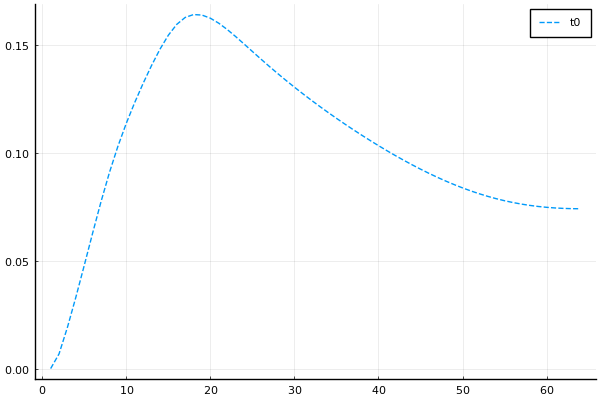

In [123]:
plot_mse_snapshot(u_pred, u, collect(LinRange(0., 0.5, 64)))

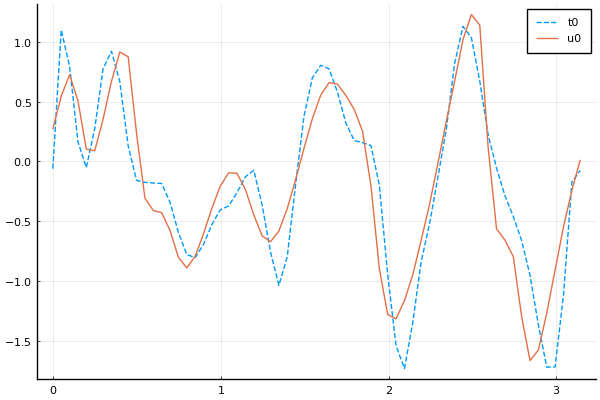

In [124]:
x = collect(LinRange(0., pi, 64));
plt = plot(x, u_pred[:, 10], linestyle=:dash, label="t0")
plot!(plt, x, u[:, 10], label="u0")

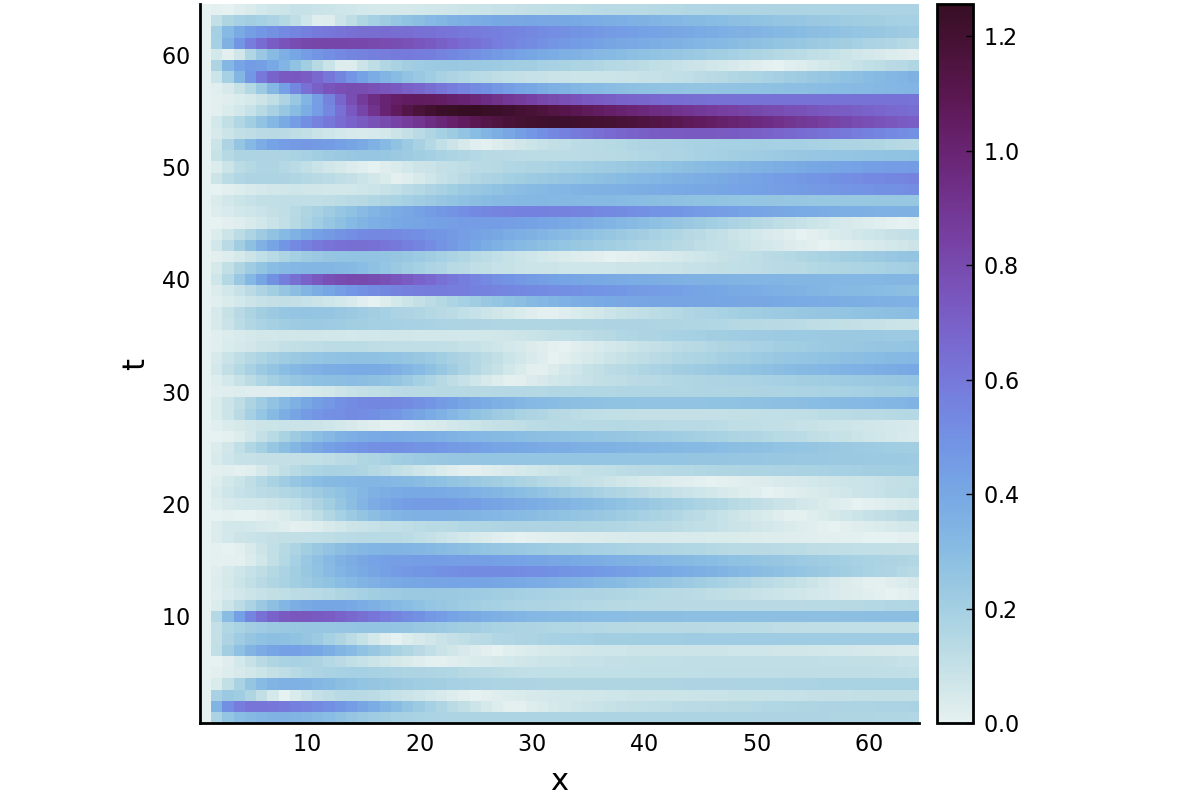

In [125]:
GraphicTools.show_err(hcat(u_pred.u...), u, "")

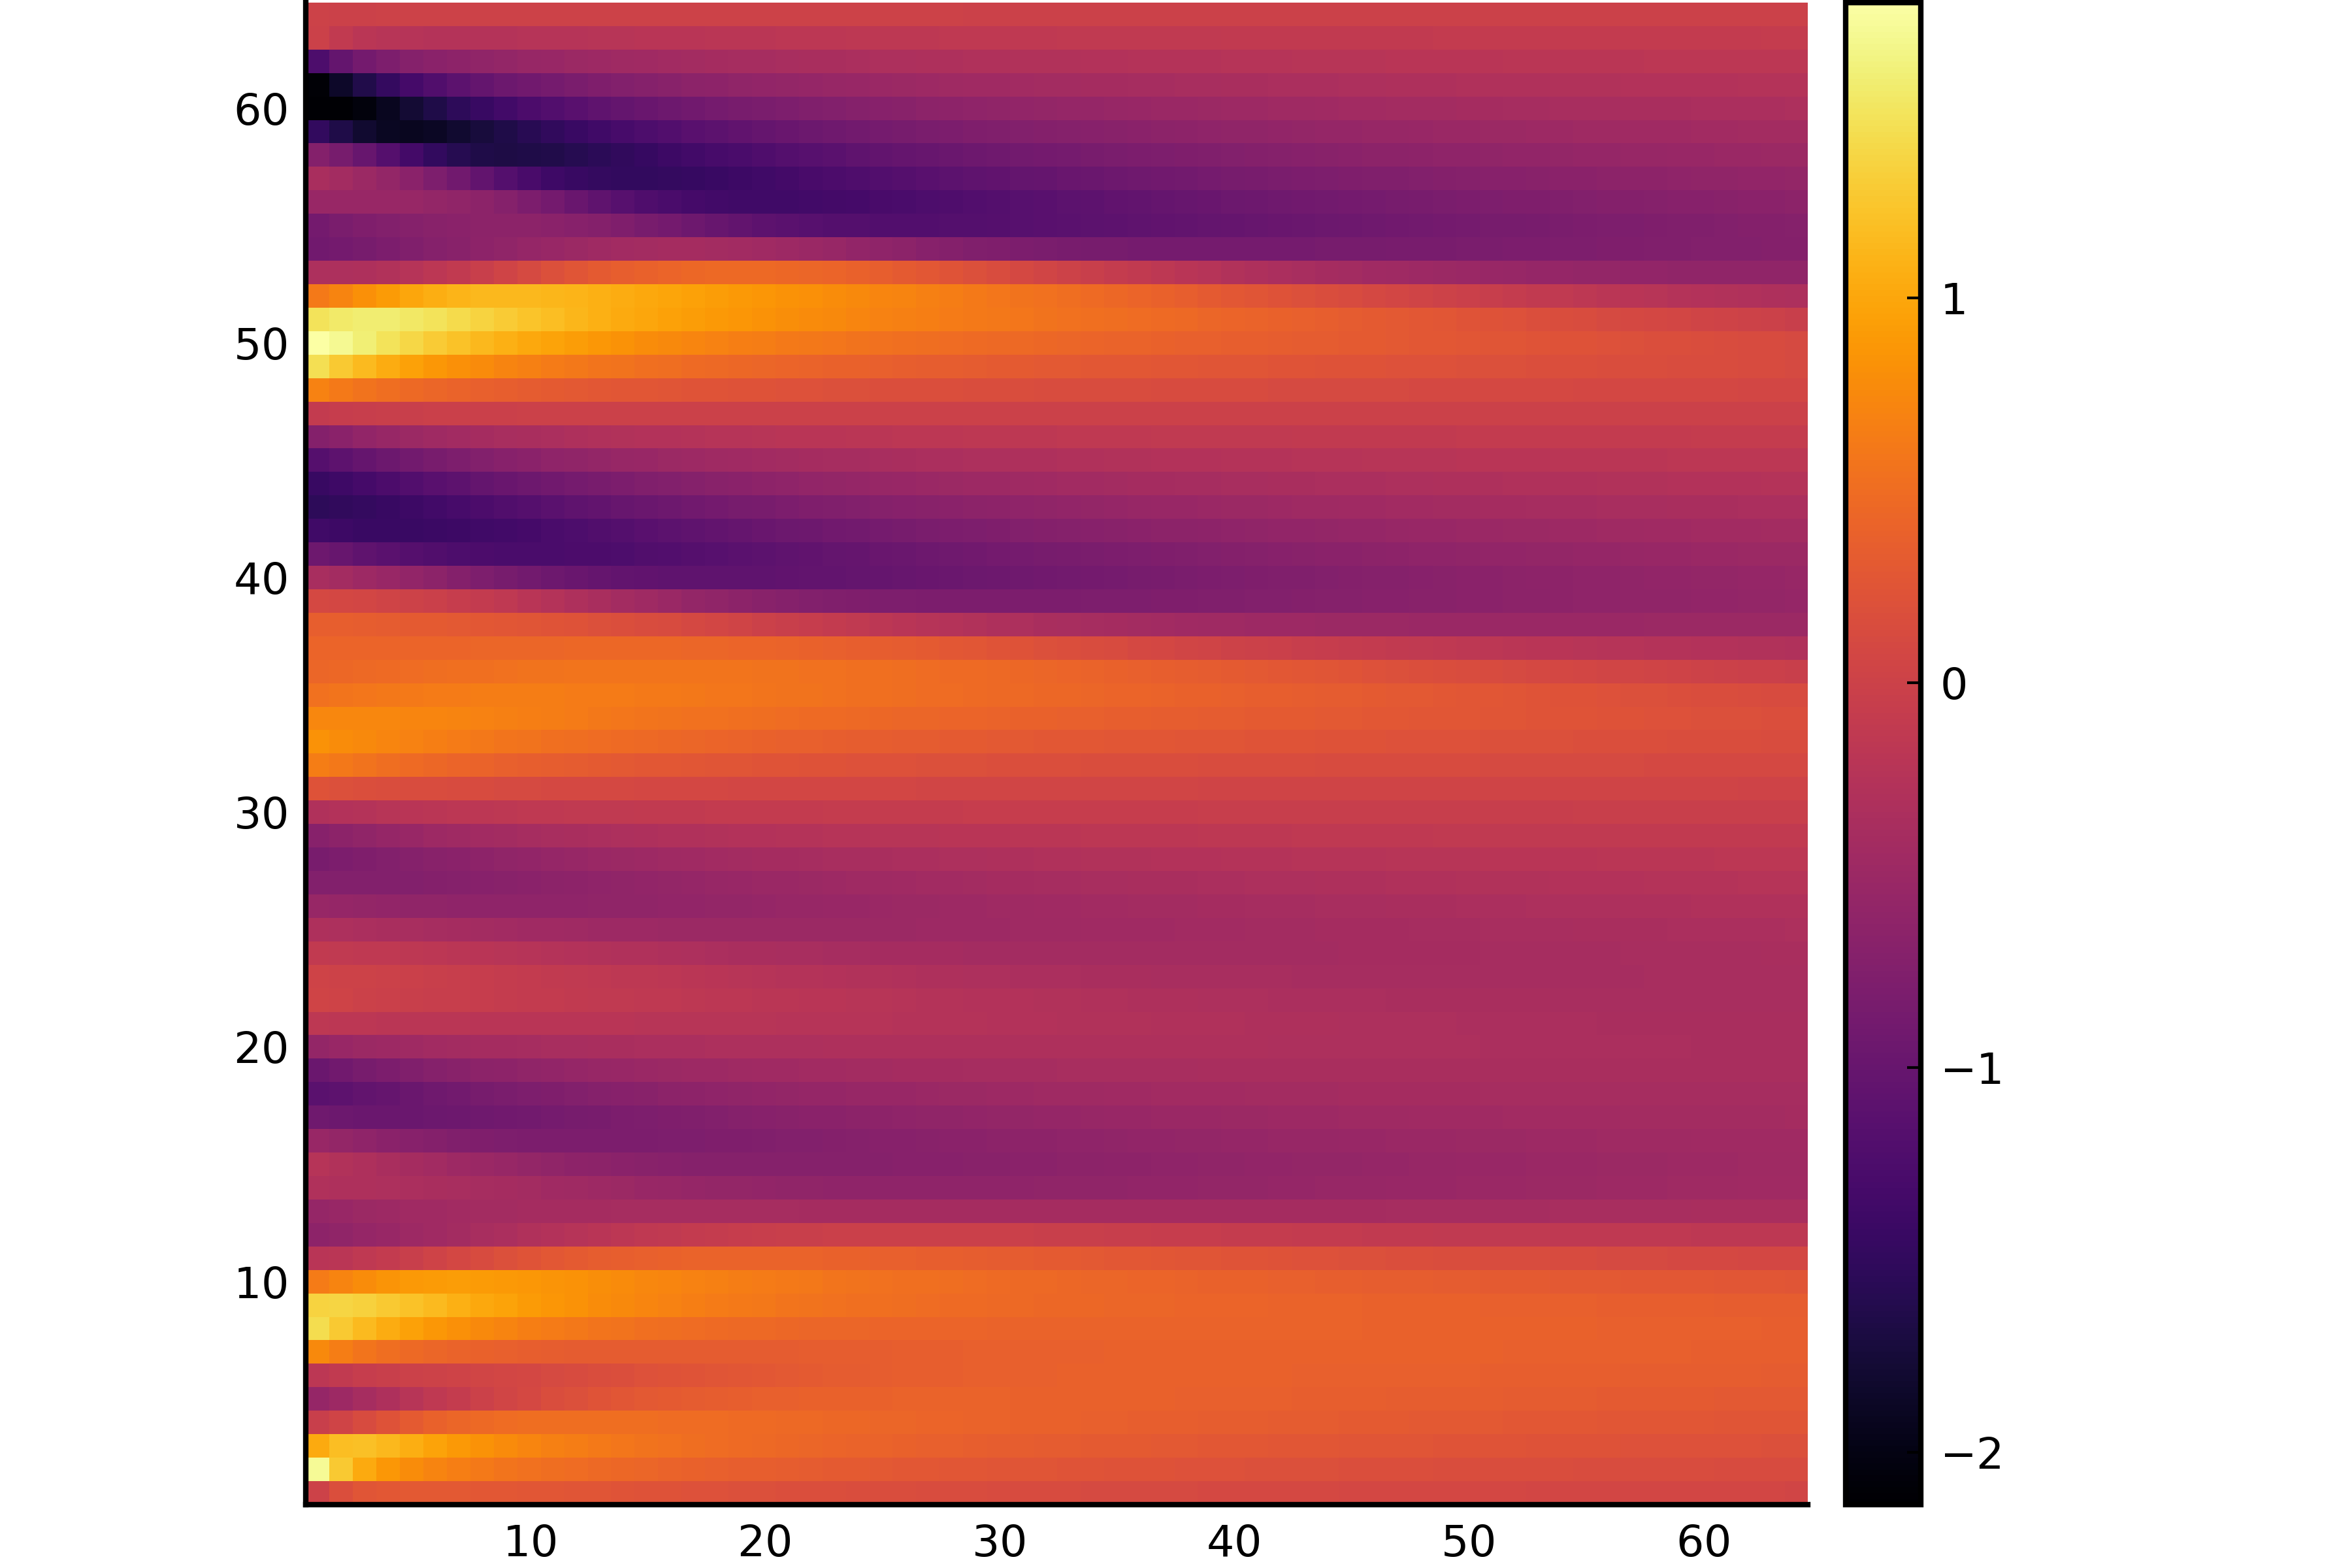

In [126]:
GraphicTools.show_state(u, "")

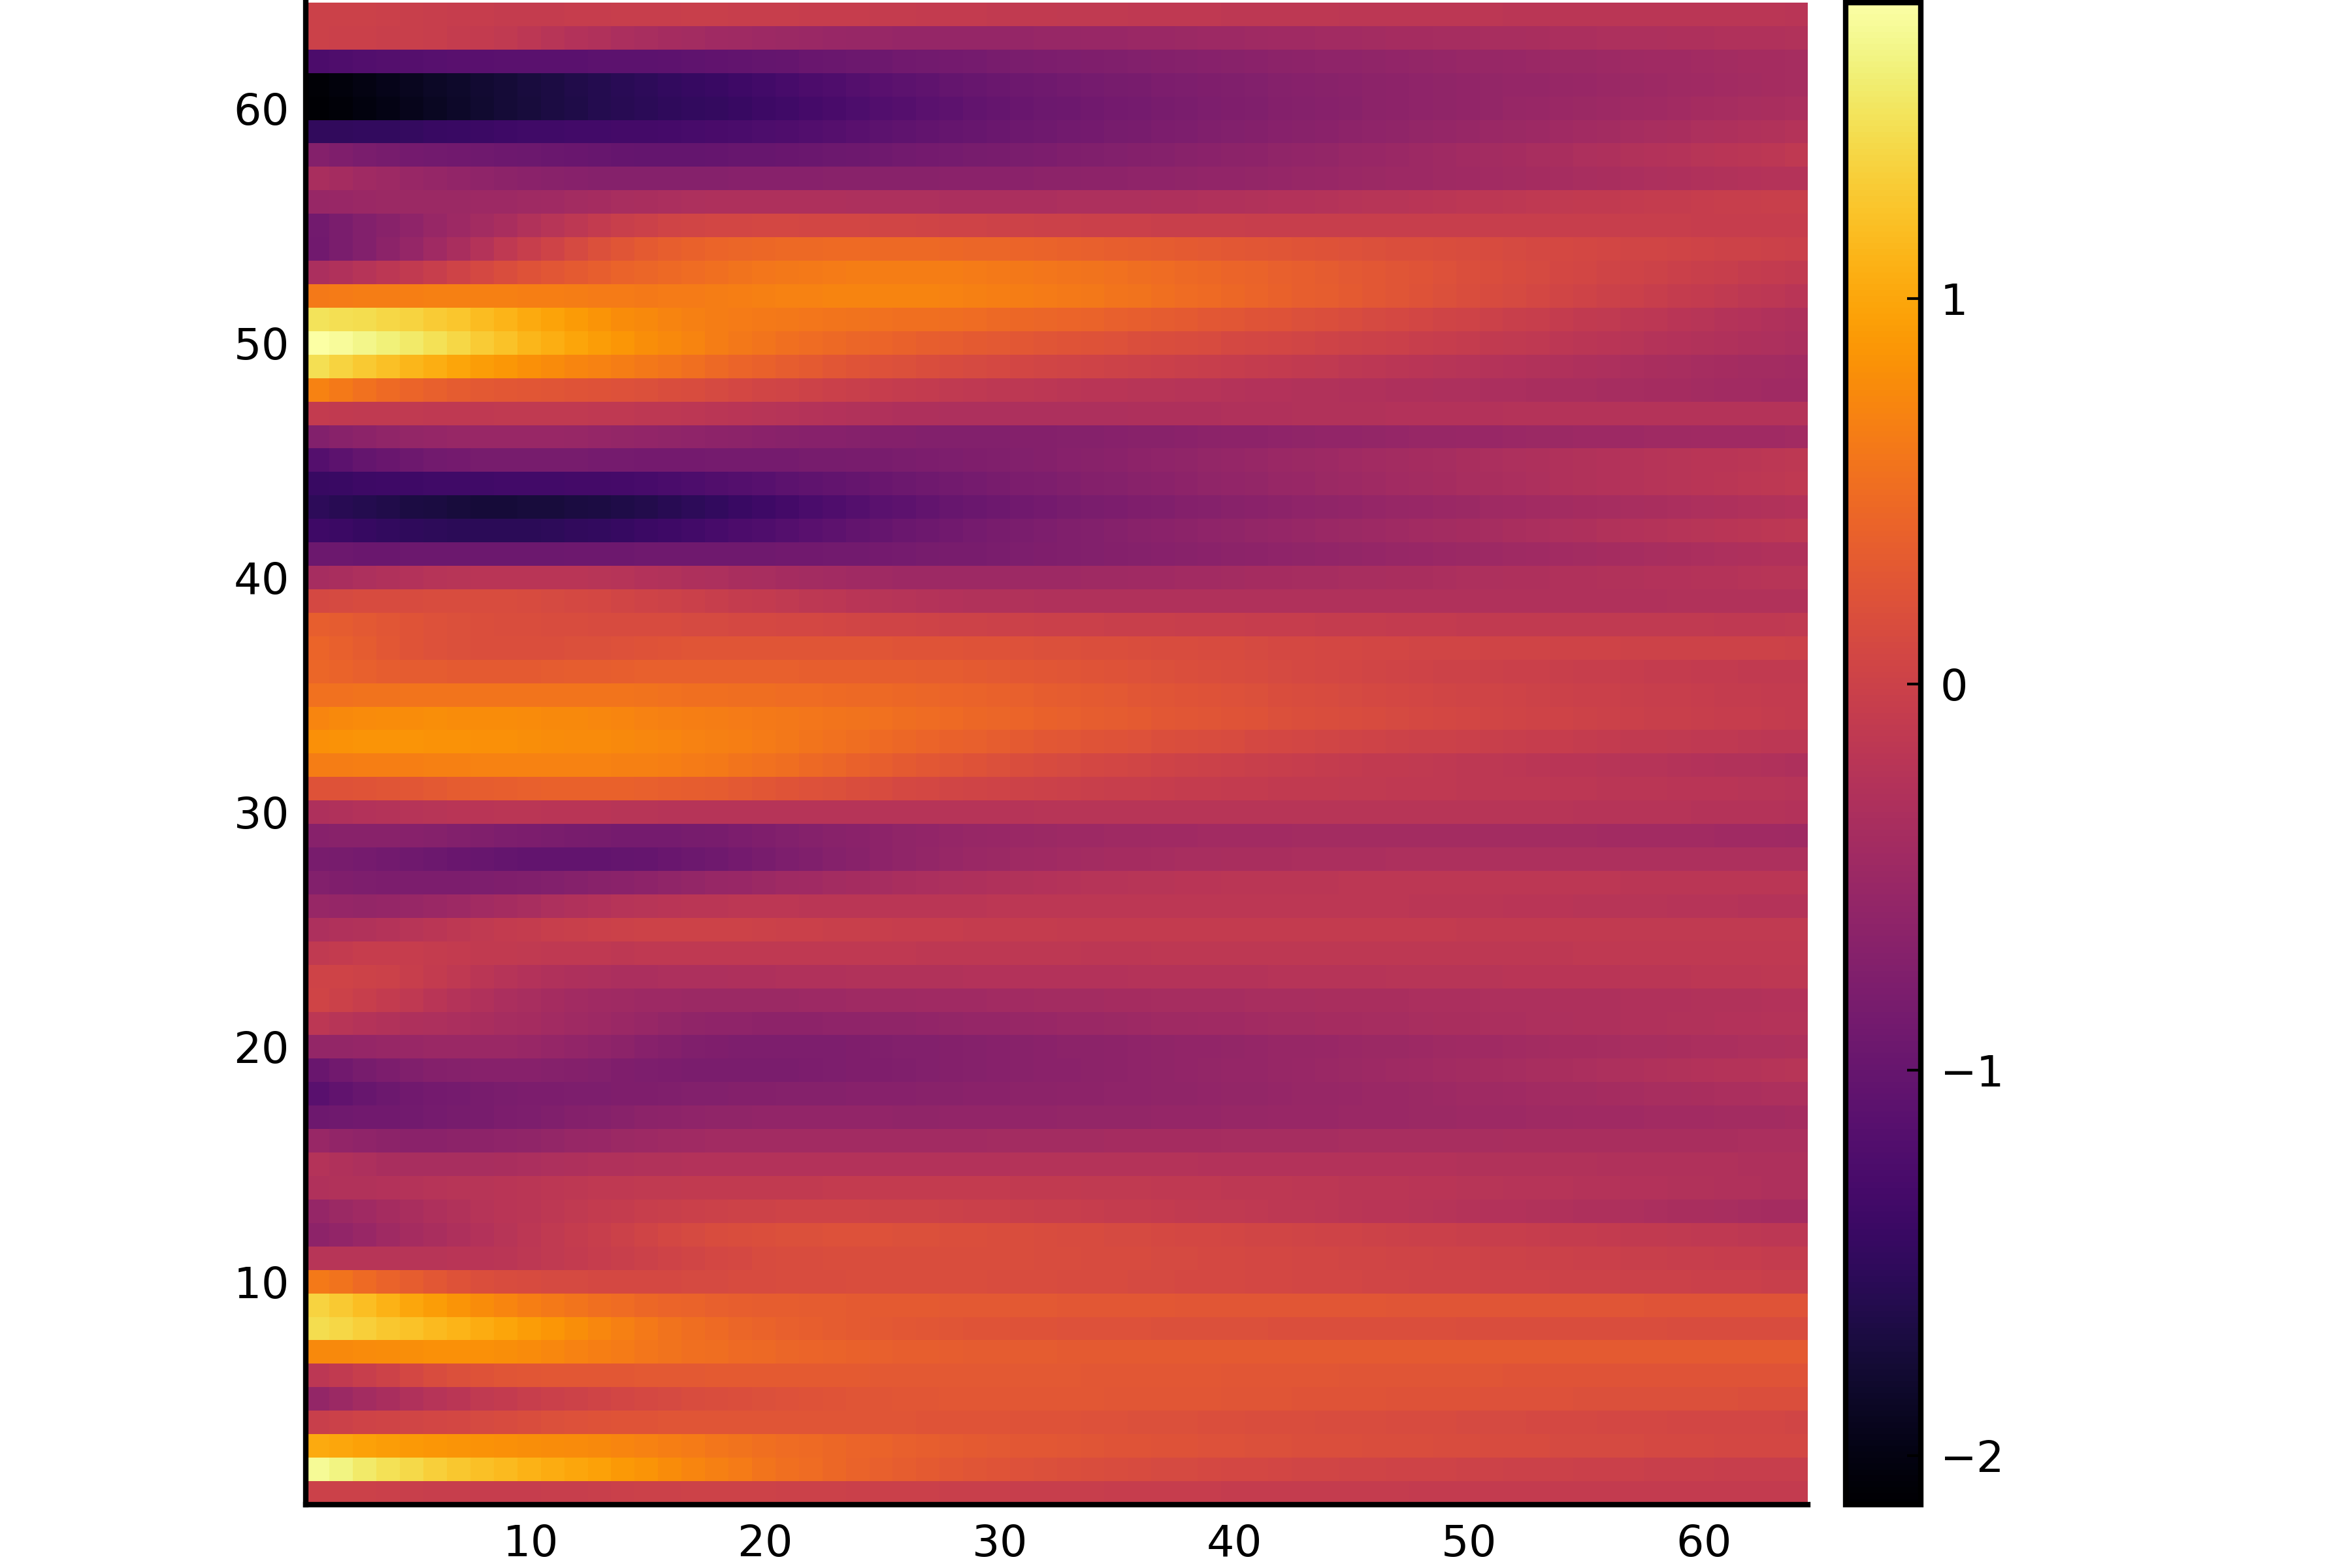

In [127]:
GraphicTools.show_state(hcat(u_pred.u...), "")

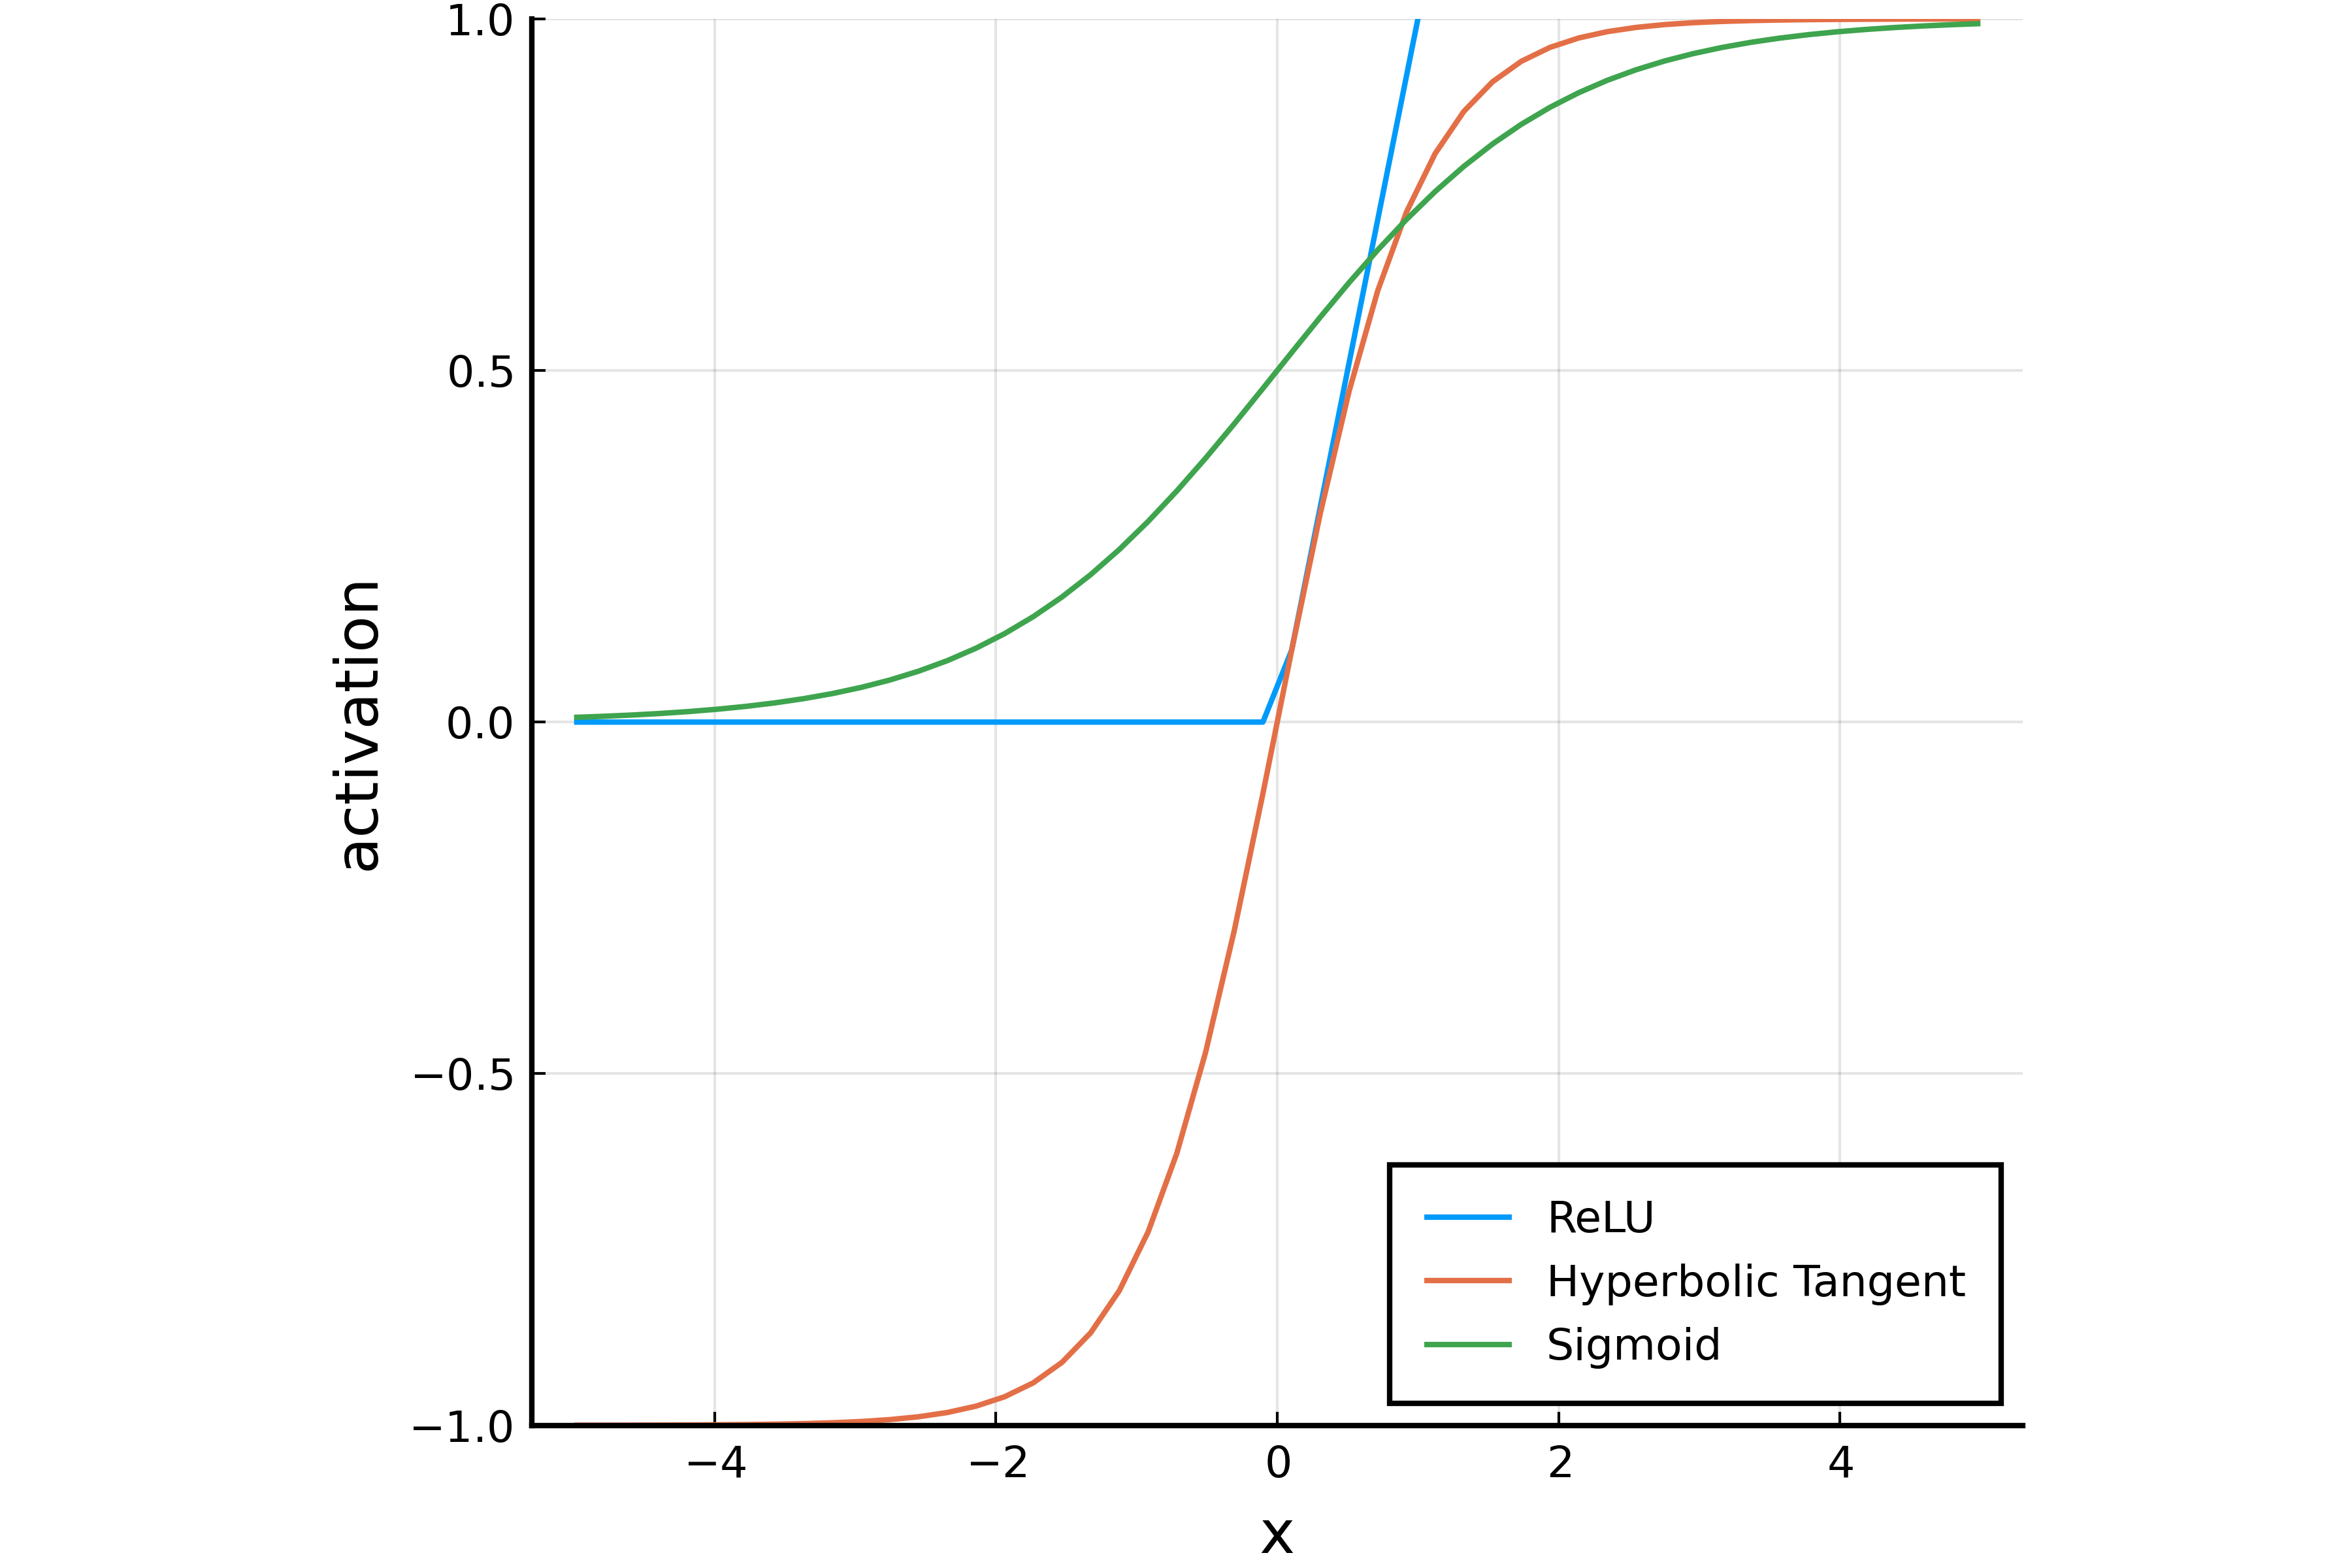

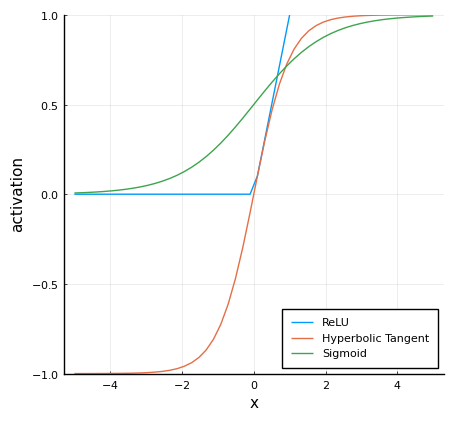